In [101]:
import sys
import os

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [102]:
# retrive data 
df = pd.read_csv("./core_exchange.csv", 
                #  index_col=0, 
                 parse_dates=True)

df.head()

,id,currency_name,bank_name,buy_rate,sell_rate,increment_amount,created_at,updated_at
0,1300,USD,Hibret Bank,105.1586,118.8292,NaN,2024-08-25 09:05:28.687571+00,2024-08-25 09:05:28.687592+00
1,2,USD,Bank of Abyssinia,104.6247,117.1797,NaN,2024-08-23 03:05:19.612498+00,2024-08-23 03:05:19.612571+00
2,3,GBP,Bank of Abyssinia,130.4970,146.1566,NaN,2024-08-23 03:05:19.618773+00,2024-08-23 03:05:19.618785+00
3,4,EUR,Bank of Abyssinia,116.6042,130.5967,NaN,2024-08-23 03:05:19.619882+00,2024-08-23 03:05:19.619893+00
4,5,AED,Bank of Abyssinia,28.4879,31.9064,NaN,2024-08-23 03:05:19.620869+00,2024-08-23 03:05:19.620877+00


In [103]:
print("Sum of total rows in the DataFrame:")
print(len(df))
print("Missing values in each column:")
print(df.isnull().sum())

print("\nData types of each column:")
print(df.dtypes)

print("\nSummary statistics of the DataFrame:")
print(df.describe())

Sum of total rows in the DataFrame:
134801
Missing values in each column:
id                       0
currency_name            0
bank_name                0
buy_rate                 0
sell_rate                0
increment_amount    134801
created_at               0
updated_at               0
dtype: int64

Data types of each column:
id                    int64
currency_name        object
bank_name            object
buy_rate            float64
sell_rate           float64
increment_amount    float64
created_at           object
updated_at           object
dtype: object

Summary statistics of the DataFrame:
                  id       buy_rate      sell_rate  increment_amount
count  134801.000000  134801.000000  134801.000000               0.0
mean    71237.264048      90.706025     179.986443               NaN
std     39233.725897      63.469969    7270.592196               NaN
min         2.000000      -1.000000      -1.000000               NaN
25%     37704.000000      32.236600      33.3877

In [104]:
# drop the increment_amount -> all are NaN
df.drop(columns=["increment_amount"], inplace=True)

In [105]:
# convert the date columns to datetime (auto-infer format, handle mixed formats)
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed', dayfirst=True)
df['updated_at'] = pd.to_datetime(df['updated_at'], format='mixed', dayfirst=True)

In [106]:
df.head()

,id,currency_name,bank_name,buy_rate,sell_rate,created_at,updated_at
0,1300,USD,Hibret Bank,105.1586,118.8292,2024-08-25 09:05:28.687571+00:00,2024-08-25 09:05:28.687592+00:00
1,2,USD,Bank of Abyssinia,104.6247,117.1797,2024-08-23 03:05:19.612498+00:00,2024-08-23 03:05:19.612571+00:00
2,3,GBP,Bank of Abyssinia,130.4970,146.1566,2024-08-23 03:05:19.618773+00:00,2024-08-23 03:05:19.618785+00:00
3,4,EUR,Bank of Abyssinia,116.6042,130.5967,2024-08-23 03:05:19.619882+00:00,2024-08-23 03:05:19.619893+00:00
4,5,AED,Bank of Abyssinia,28.4879,31.9064,2024-08-23 03:05:19.620869+00:00,2024-08-23 03:05:19.620877+00:00


In [107]:
# out lier detection - using rolling window 

# Set datetime index
df = df.set_index('created_at').sort_index()

# Sort values for groupby rolling
df = df.sort_values(['currency_name', 'created_at'])

def rolling_outlier_detection(group, window=7, k=1.5):
    # Calculate rolling median and IQR for buy_rate
    buy_median = group['buy_rate'].rolling(window=window, center=True).median()
    buy_q1 = group['buy_rate'].rolling(window=window, center=True).quantile(0.25)
    buy_q3 = group['buy_rate'].rolling(window=window, center=True).quantile(0.75)
    buy_iqr = buy_q3 - buy_q1
    
    buy_lower = buy_median - k * buy_iqr
    buy_upper = buy_median + k * buy_iqr
    buy_outliers = (group['buy_rate'] < buy_lower) | (group['buy_rate'] > buy_upper)
    
    # Calculate rolling median and IQR for sell_rate
    sell_median = group['sell_rate'].rolling(window=window, center=True).median()
    sell_q1 = group['sell_rate'].rolling(window=window, center=True).quantile(0.25)
    sell_q3 = group['sell_rate'].rolling(window=window, center=True).quantile(0.75)
    sell_iqr = sell_q3 - sell_q1
    
    sell_lower = sell_median - k * sell_iqr
    sell_upper = sell_median + k * sell_iqr
    sell_outliers = (group['sell_rate'] < sell_lower) | (group['sell_rate'] > sell_upper)
    
    return pd.DataFrame({
        'buy_rate': group['buy_rate'],
        'buy_rolling_median': buy_median,
        'buy_lower_bound': buy_lower,
        'buy_upper_bound': buy_upper,
        'buy_is_outlier': buy_outliers,
        
        'sell_rate': group['sell_rate'],
        'sell_rolling_median': sell_median,
        'sell_lower_bound': sell_lower,
        'sell_upper_bound': sell_upper,
        'sell_is_outlier': sell_outliers,
    }, index=group.index)

# Apply per currency_name
result = df.groupby('currency_name').apply(rolling_outlier_detection).reset_index(level=0)

# Inspect flagged outliers
print(result[result['buy_is_outlier'] | result['sell_is_outlier']].to_csv("./updated_core_exchange.csv"))

/tmp/ipykernel_386851/2904360151.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('currency_name').apply(rolling_outlier_detection).reset_index(level=0)


None



Frequency of each currency:
currency_name
EUR                20024
GBP                20005
USD                19976
AED                17520
SAR                14164
CAD                11832
CHF                 9055
CNY                 4963
SEK                 3622
NOK                 2627
JPY                 2017
DKK                 1503
AUD                 1343
ZAR                 1289
KWD                 1198
INR                 1193
KES                 1192
DJF                 1190
SDR                   67
XAF                    9
Canadian Dollar        8
GBE                    4
Name: count, dtype: int64

Frequency of each bank_name:
bank_name
Commercial Bank of Ethiopia     20482
Bank of Abyssinia               11660
Global Bank                      8331
Tsehay Bank                      7518
Amhara Bank                      7485
Ahadu Bank                       7470
Siinqee Bank                     7437
Enat Bank                        7054
Awash Bank                       6726

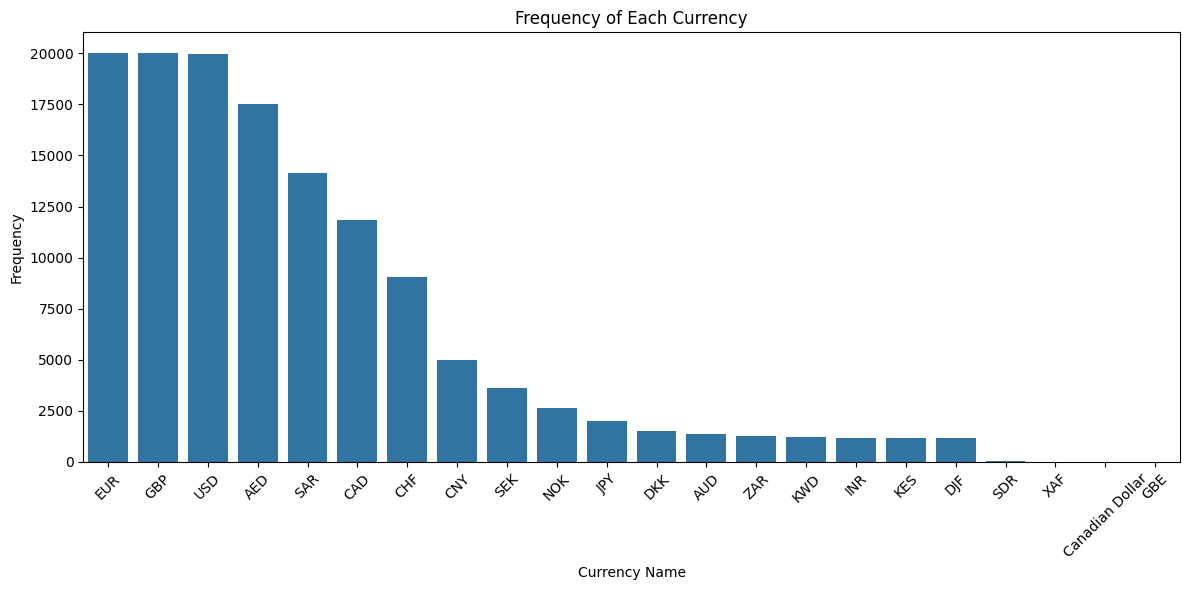

In [108]:
# descriptive analysis - 

# frequency of currency_name

print("\nFrequency of each currency:")
print(df['currency_name'].value_counts())

print("\nFrequency of each bank_name:")
print(df['bank_name'].value_counts())

# plot the frequency of currency_name
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='currency_name', order=df['currency_name'].value_counts
().index)
plt.title('Frequency of Each Currency')
plt.xticks(rotation=45)
plt.xlabel('Currency Name')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [109]:
# mean, median, and std for buy_rate and sell_rate 

print("\nMean, Median, and Standard Deviation for buy_rate:")
print("Mean:", df['buy_rate'].mean())
print("Median:", df['buy_rate'].median())
print("Standard Deviation:", df['buy_rate'].std())

print("\nMean, Median, and Standard Deviation for sell_rate:")
print("Mean:", df['sell_rate'].mean())
print("Median:", df['sell_rate'].median())
print("Standard Deviation:", df['sell_rate'].std())


Mean, Median, and Standard Deviation for buy_rate:
Mean: 90.70602469343699
Median: 108.551
Standard Deviation: 63.46996884129088

Mean, Median, and Standard Deviation for sell_rate:
Mean: 179.98644280161128
Median: 118.8292
Standard Deviation: 7270.592196080238


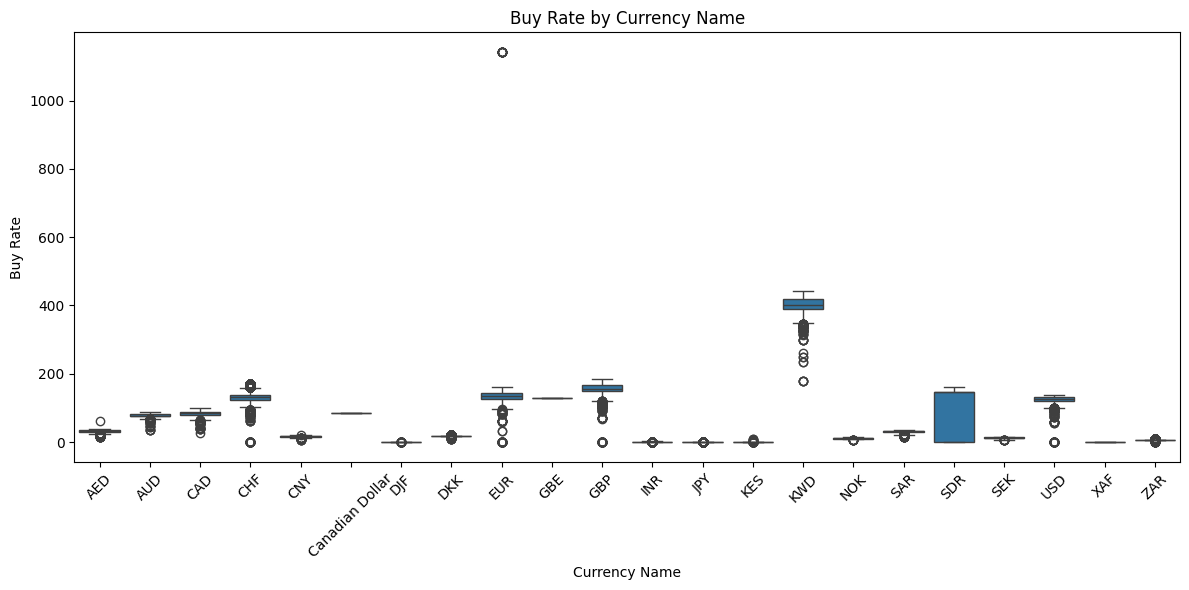

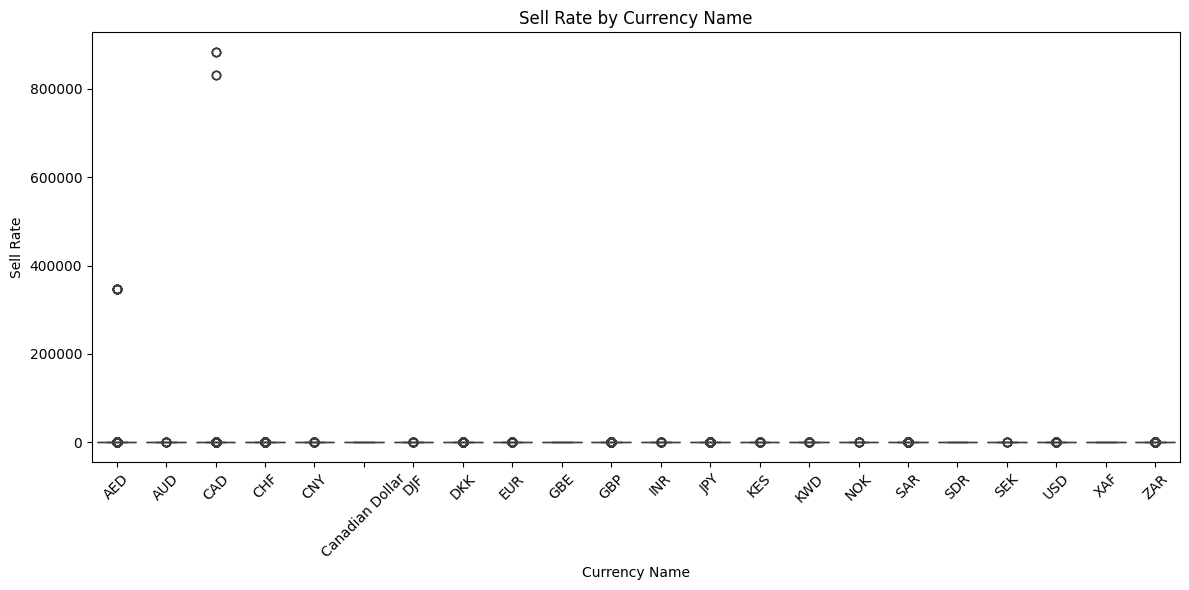

In [110]:
# Bivariate analysis 

# compare buy_rate for each currency_name
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='currency_name', y='buy_rate')
plt.title('Buy Rate by Currency Name')
plt.xticks(rotation=45)
plt.xlabel('Currency Name')
plt.ylabel('Buy Rate')
plt.tight_layout()
plt.show()

# Compare sell_rate by currency_name
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='currency_name', y='sell_rate')
plt.title('Sell Rate by Currency Name')
plt.xticks(rotation=45)
plt.xlabel('Currency Name')
plt.ylabel('Sell Rate')
plt.tight_layout()
plt.show()

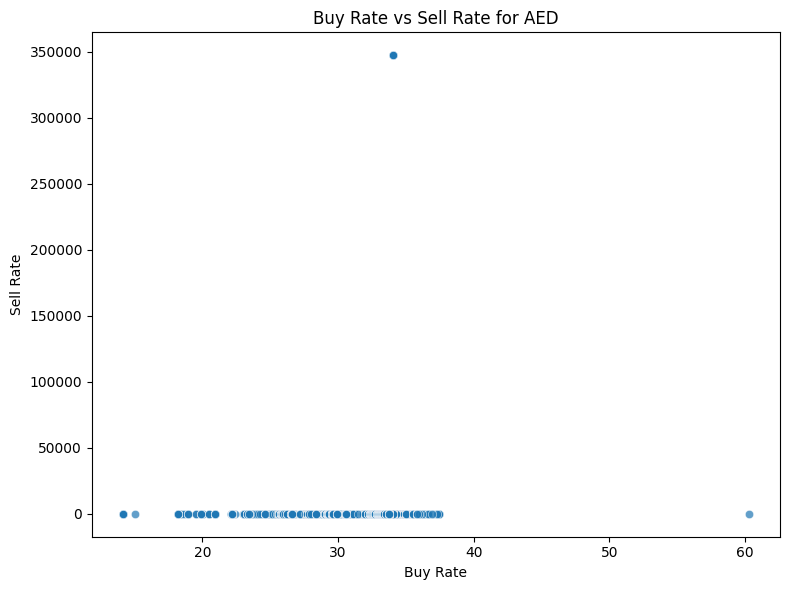


Correlation Matrix for AED:
           buy_rate  sell_rate
buy_rate   1.000000   0.014063
sell_rate  0.014063   1.000000


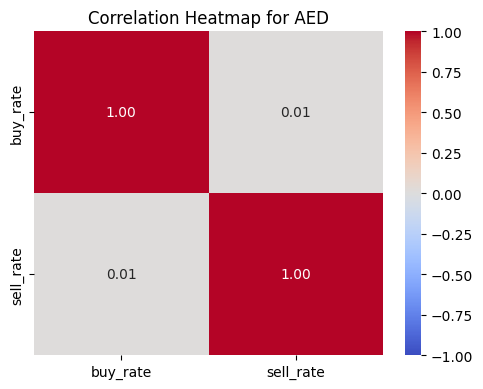

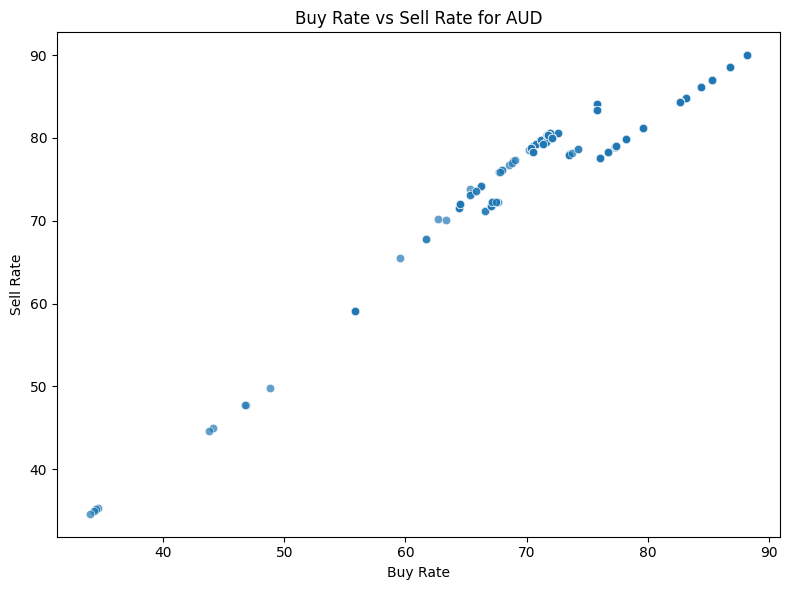


Correlation Matrix for AUD:
           buy_rate  sell_rate
buy_rate    1.00000    0.91552
sell_rate   0.91552    1.00000


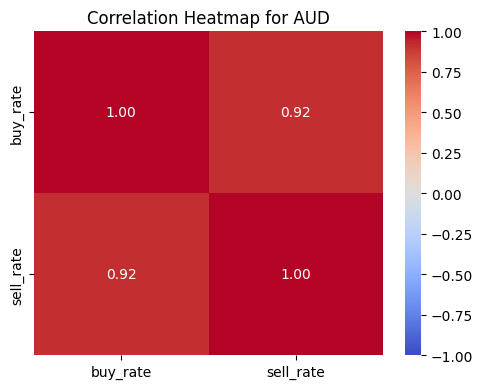

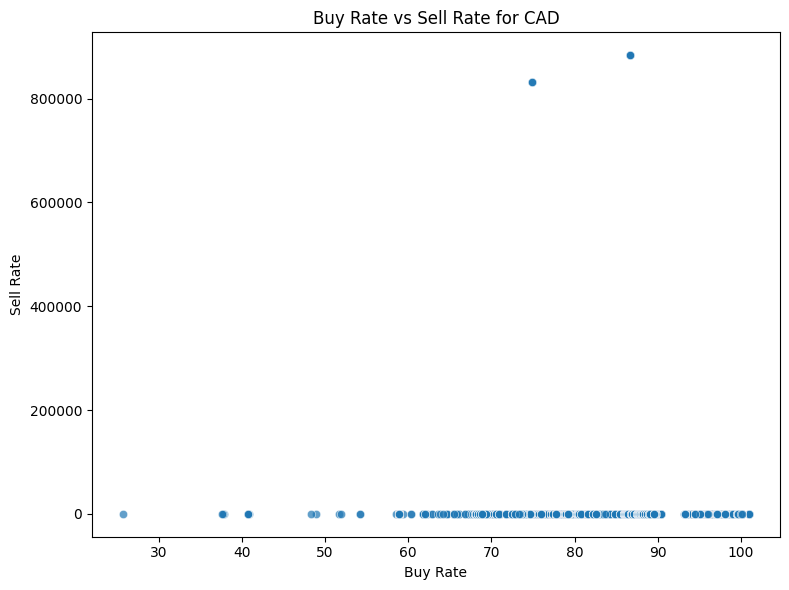


Correlation Matrix for CAD:
           buy_rate  sell_rate
buy_rate   1.000000  -0.003463
sell_rate -0.003463   1.000000


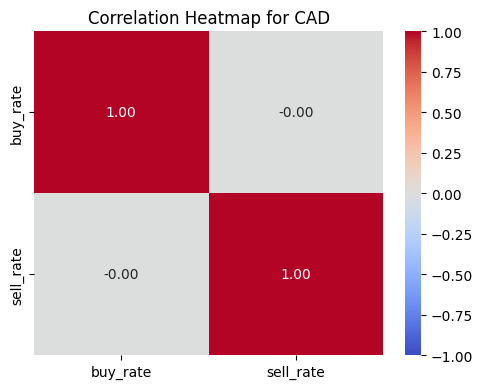

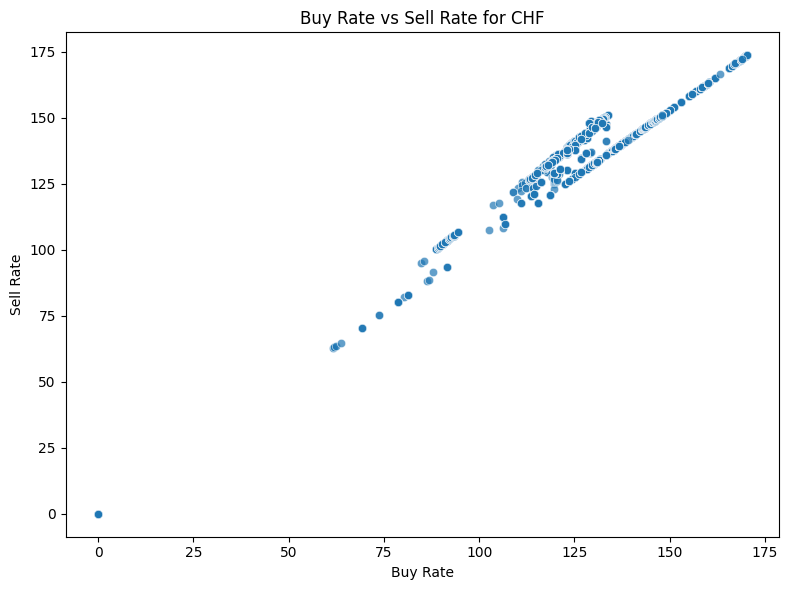


Correlation Matrix for CHF:
           buy_rate  sell_rate
buy_rate    1.00000    0.96434
sell_rate   0.96434    1.00000


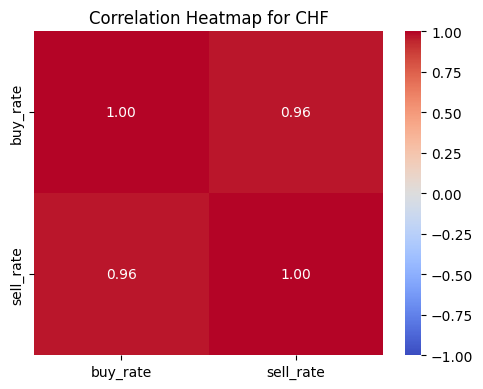

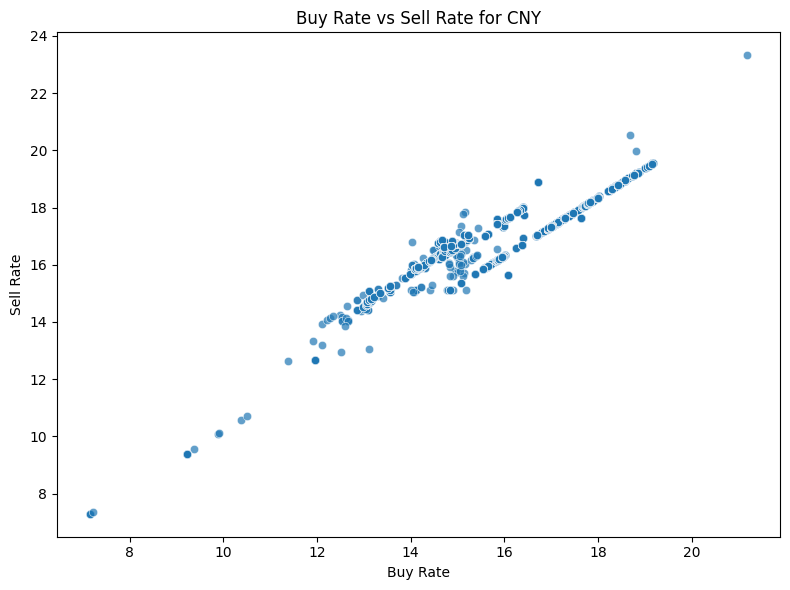


Correlation Matrix for CNY:
           buy_rate  sell_rate
buy_rate   1.000000   0.934144
sell_rate  0.934144   1.000000


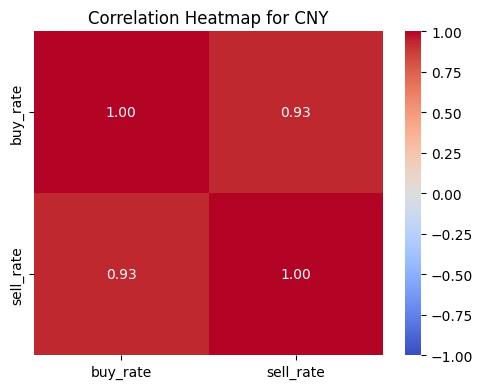

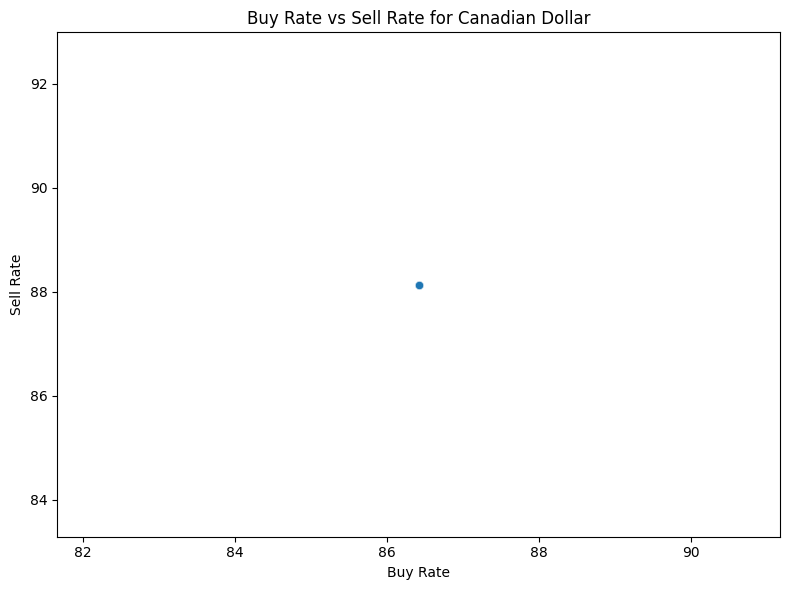


Correlation Matrix for Canadian Dollar:
           buy_rate  sell_rate
buy_rate        NaN        NaN
sell_rate       NaN        NaN


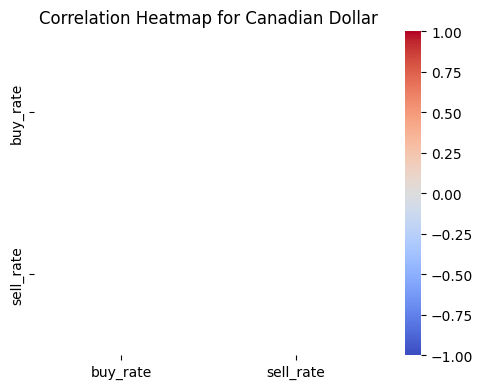

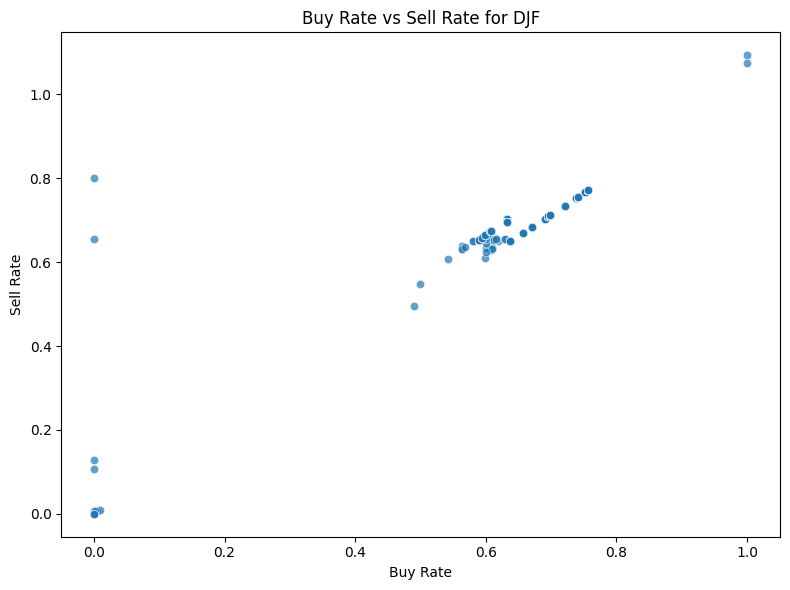


Correlation Matrix for DJF:
           buy_rate  sell_rate
buy_rate   1.000000   0.963144
sell_rate  0.963144   1.000000


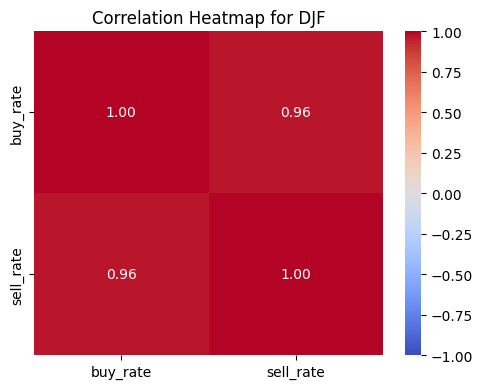

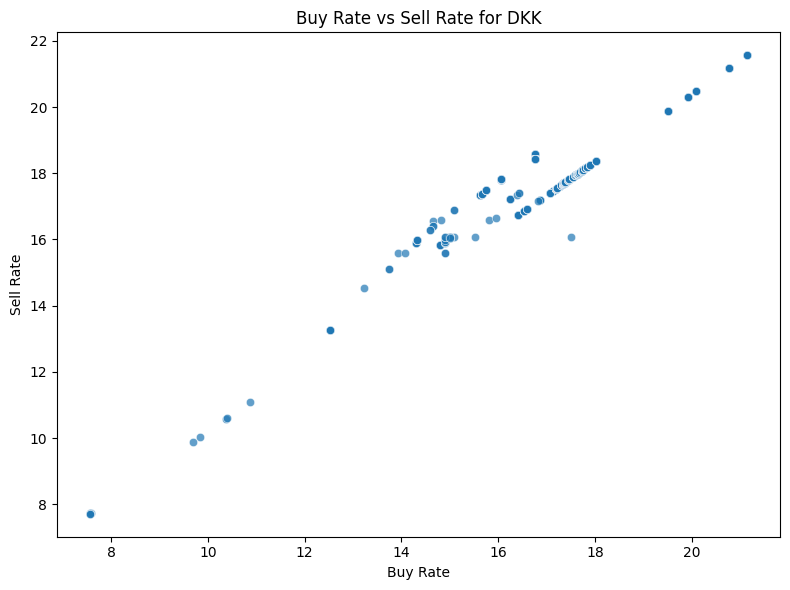


Correlation Matrix for DKK:
           buy_rate  sell_rate
buy_rate   1.000000   0.967069
sell_rate  0.967069   1.000000


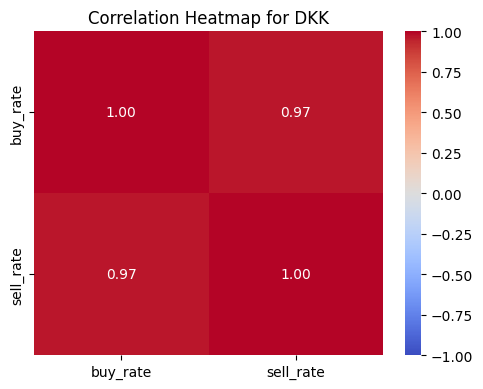

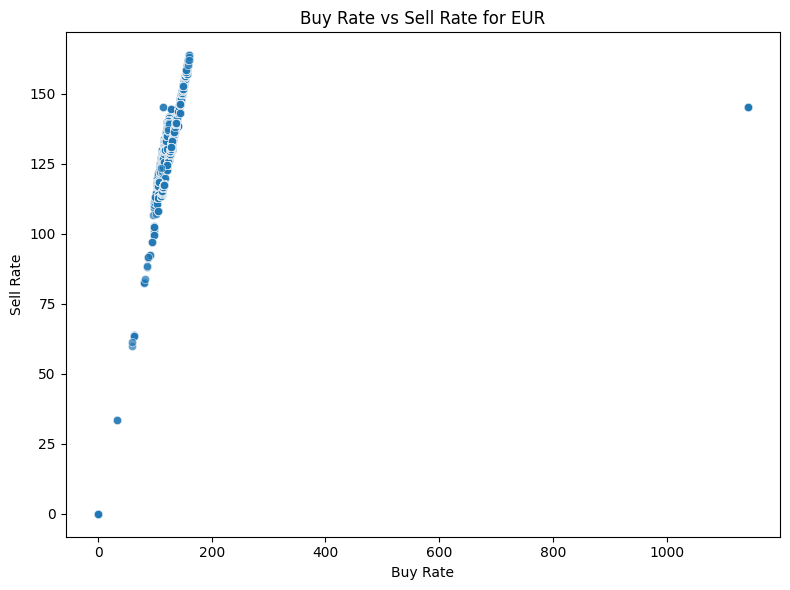


Correlation Matrix for EUR:
           buy_rate  sell_rate
buy_rate   1.000000   0.481886
sell_rate  0.481886   1.000000


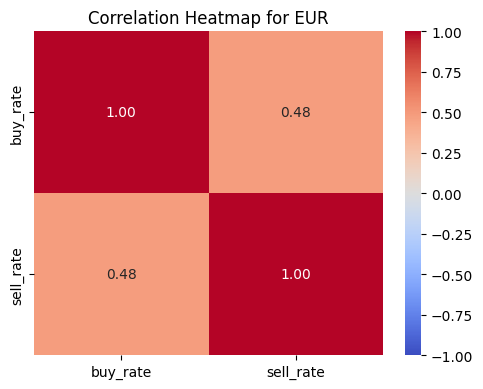

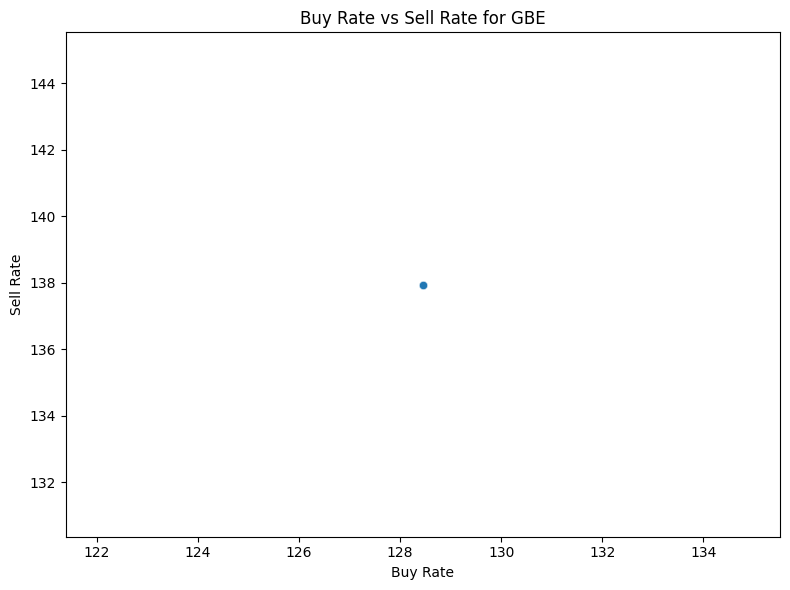


Correlation Matrix for GBE:
           buy_rate  sell_rate
buy_rate        NaN        NaN
sell_rate       NaN        NaN


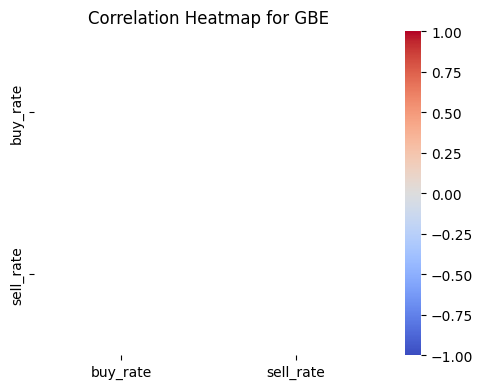

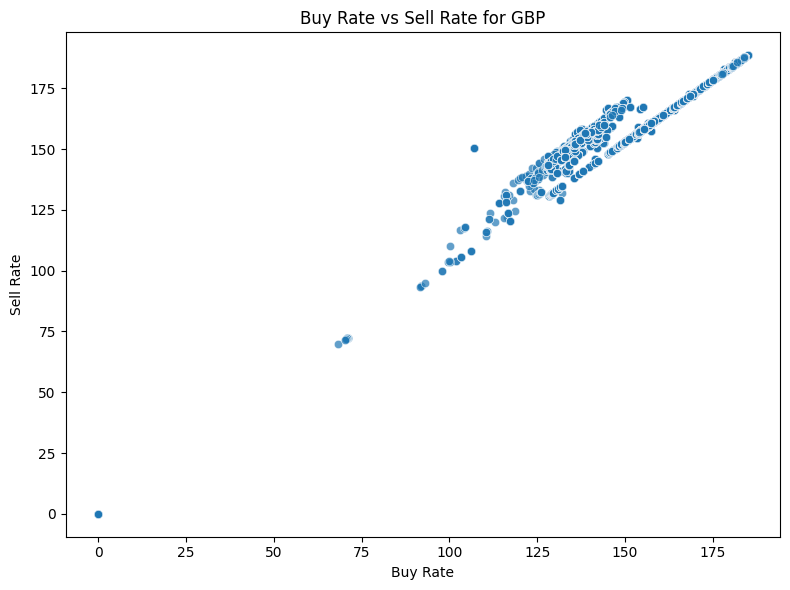


Correlation Matrix for GBP:
           buy_rate  sell_rate
buy_rate   1.000000   0.945796
sell_rate  0.945796   1.000000


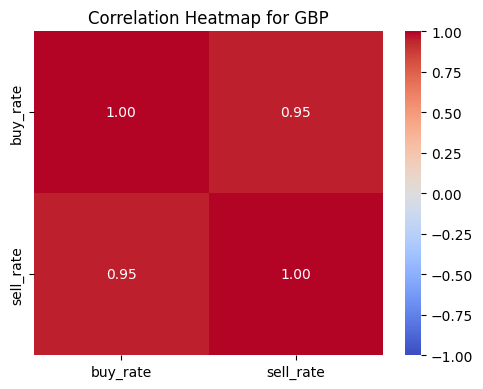

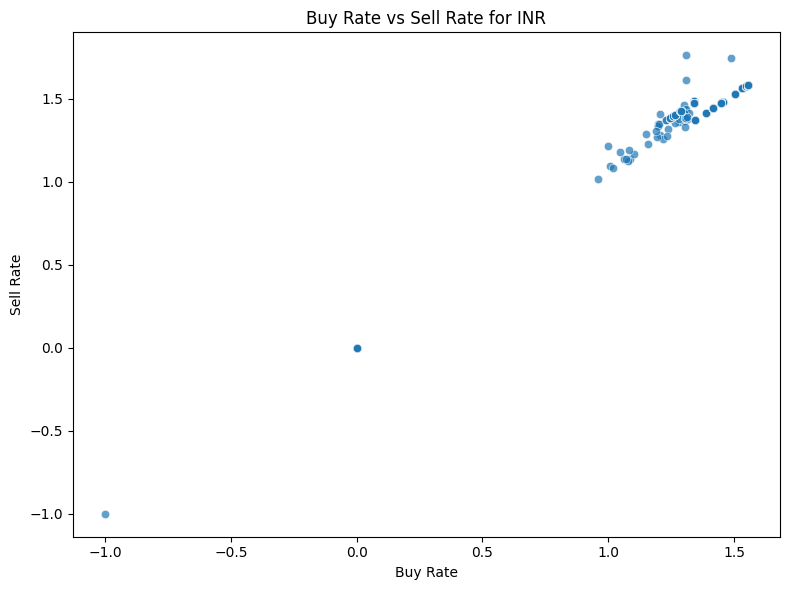


Correlation Matrix for INR:
           buy_rate  sell_rate
buy_rate   1.000000   0.982444
sell_rate  0.982444   1.000000


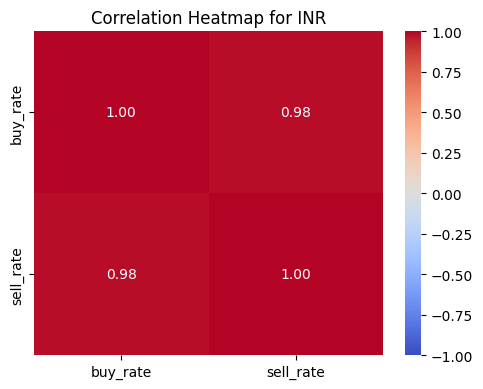

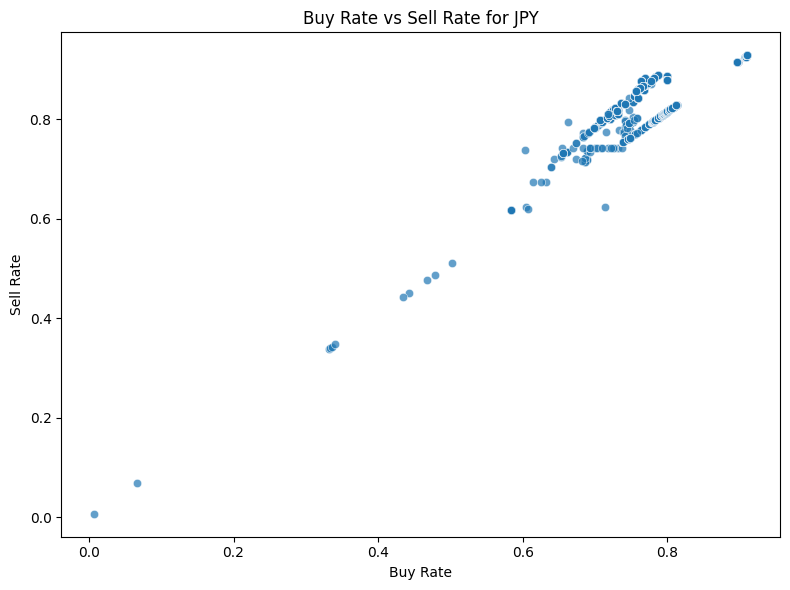


Correlation Matrix for JPY:
           buy_rate  sell_rate
buy_rate   1.000000   0.881097
sell_rate  0.881097   1.000000


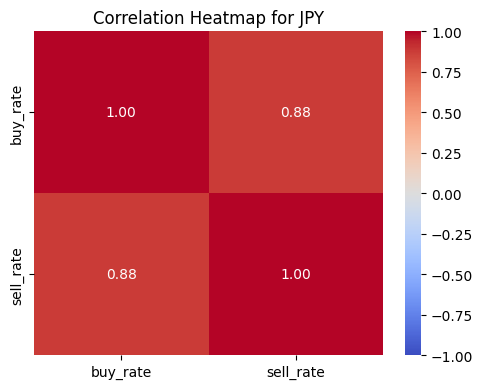

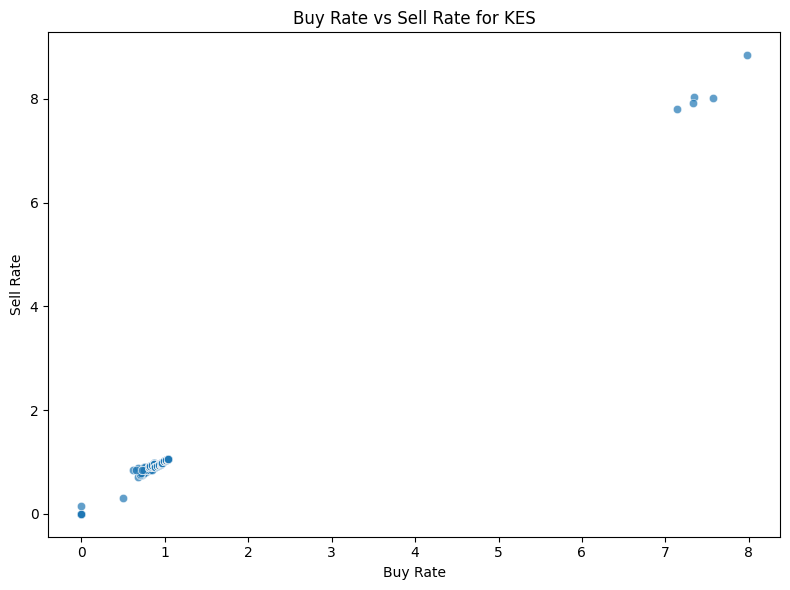


Correlation Matrix for KES:
           buy_rate  sell_rate
buy_rate   1.000000   0.997564
sell_rate  0.997564   1.000000


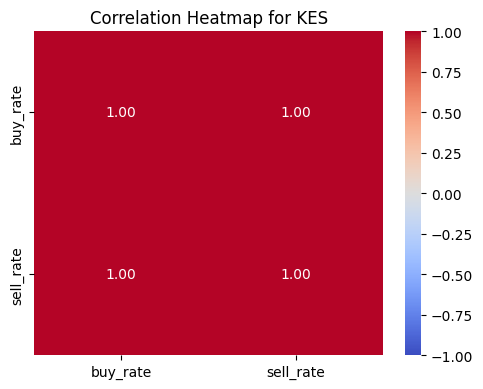

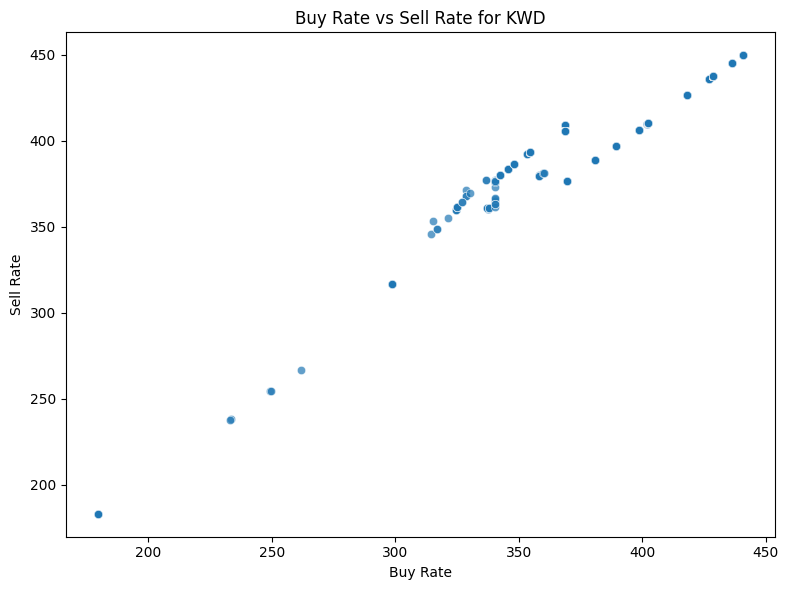


Correlation Matrix for KWD:
           buy_rate  sell_rate
buy_rate   1.000000   0.951781
sell_rate  0.951781   1.000000


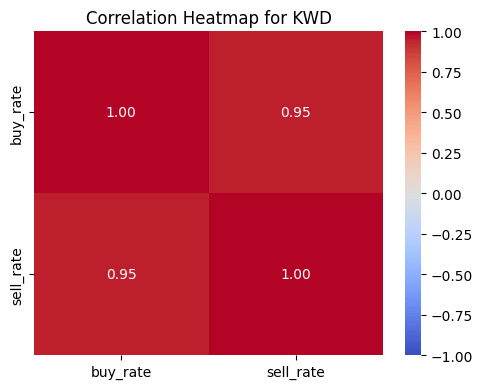

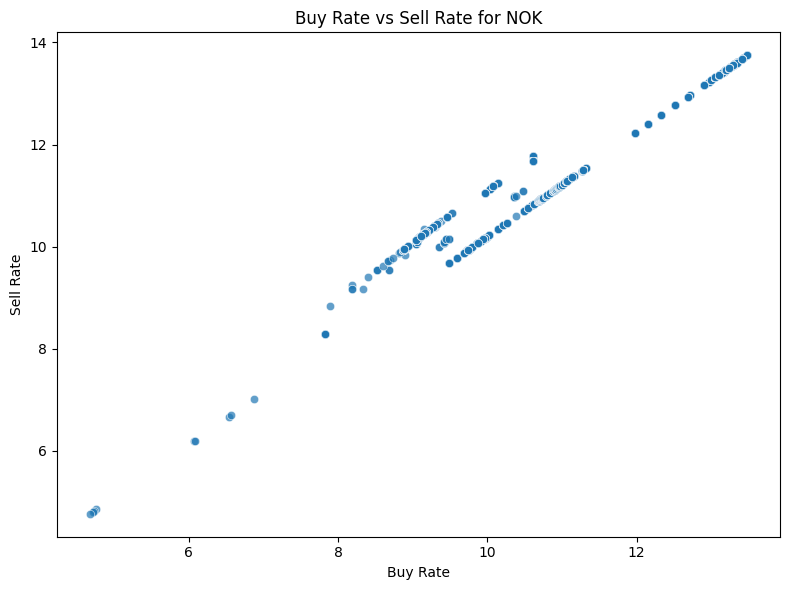


Correlation Matrix for NOK:
           buy_rate  sell_rate
buy_rate   1.000000   0.973947
sell_rate  0.973947   1.000000


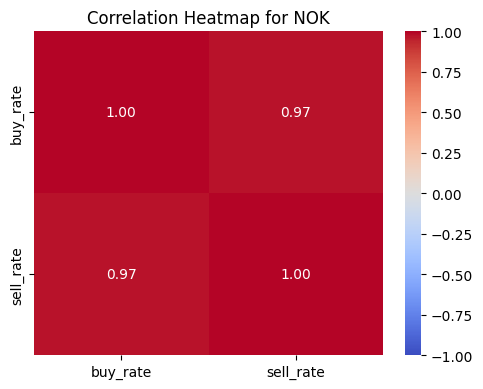

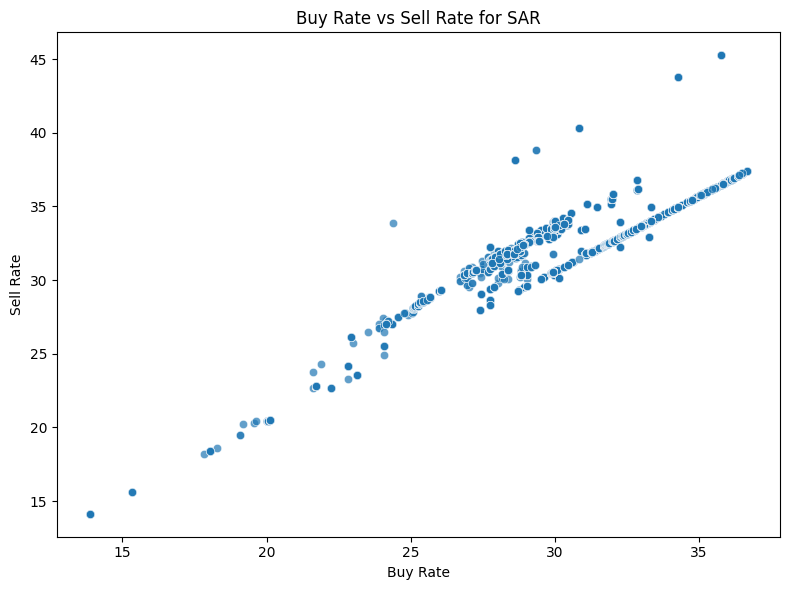


Correlation Matrix for SAR:
           buy_rate  sell_rate
buy_rate   1.000000   0.950169
sell_rate  0.950169   1.000000


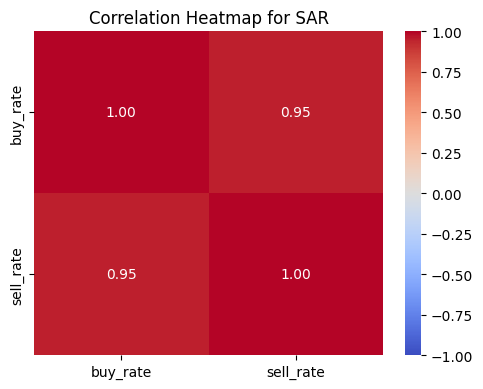

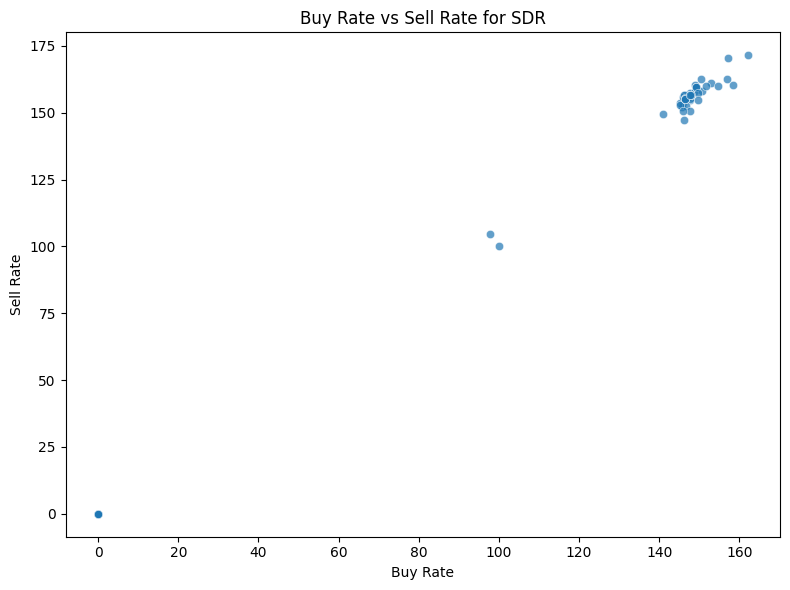


Correlation Matrix for SDR:
           buy_rate  sell_rate
buy_rate    1.00000    0.99957
sell_rate   0.99957    1.00000


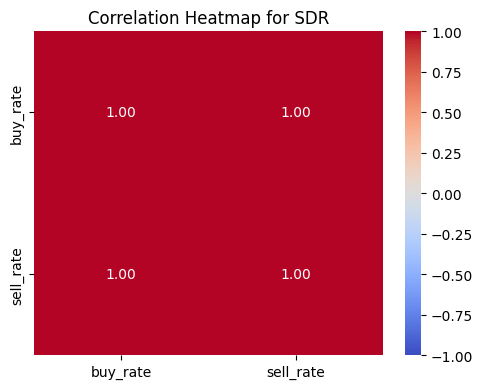

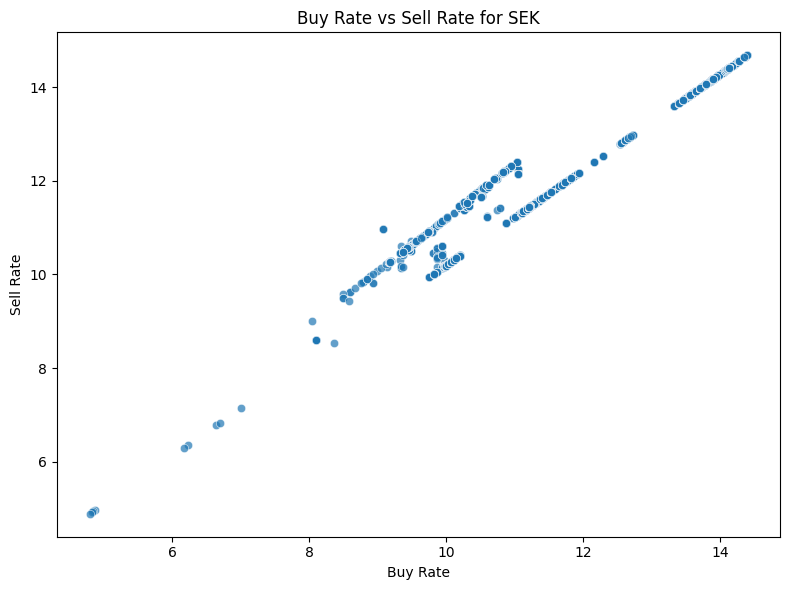


Correlation Matrix for SEK:
           buy_rate  sell_rate
buy_rate   1.000000   0.966568
sell_rate  0.966568   1.000000


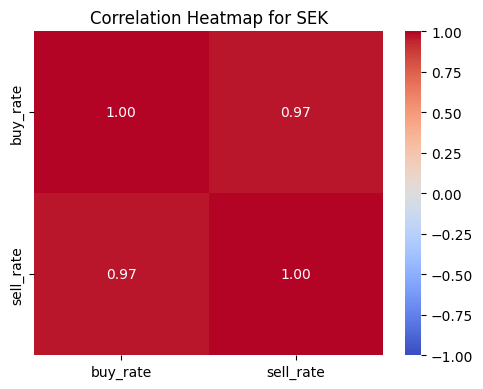

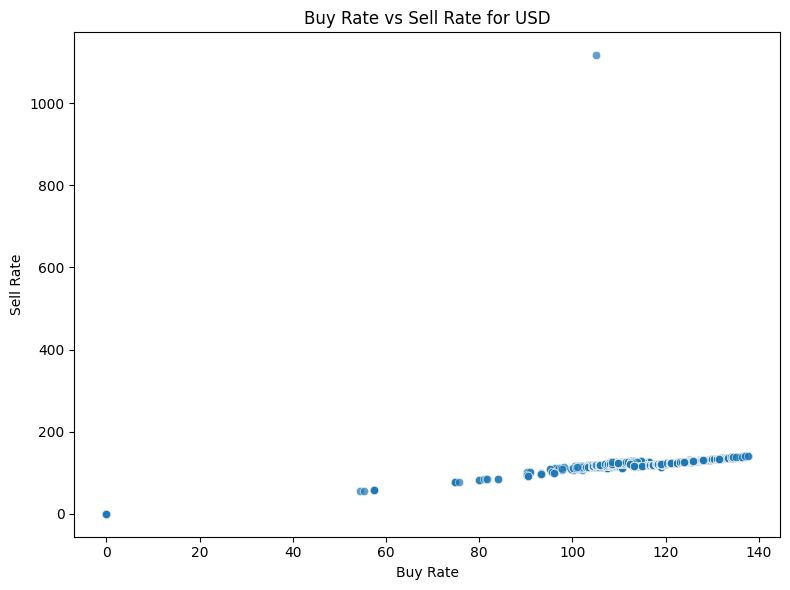


Correlation Matrix for USD:
           buy_rate  sell_rate
buy_rate   1.000000   0.713851
sell_rate  0.713851   1.000000


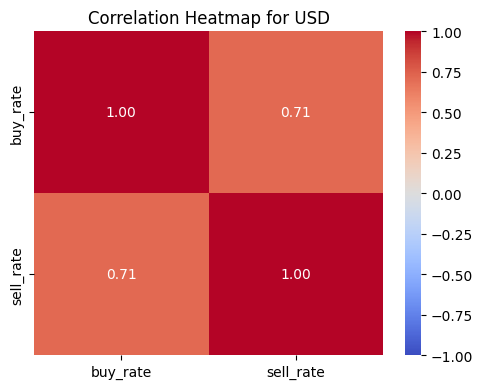

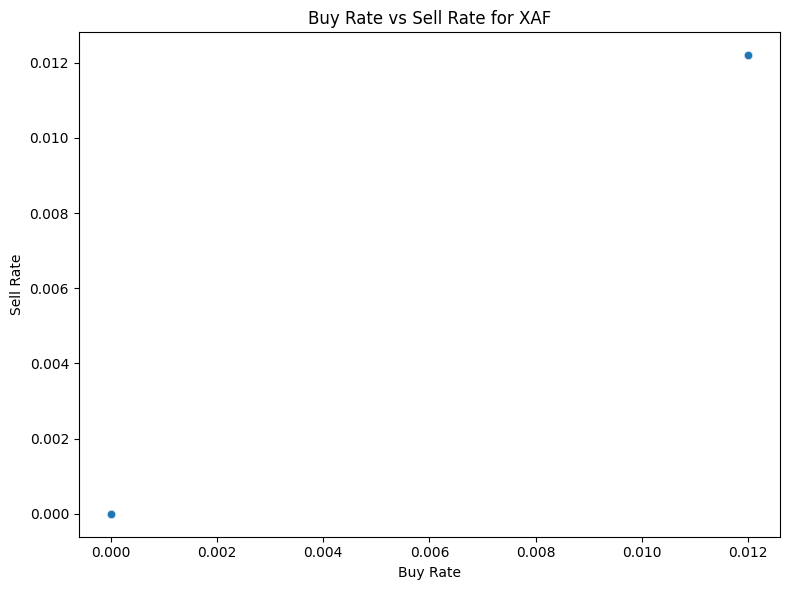


Correlation Matrix for XAF:
           buy_rate  sell_rate
buy_rate        1.0        1.0
sell_rate       1.0        1.0


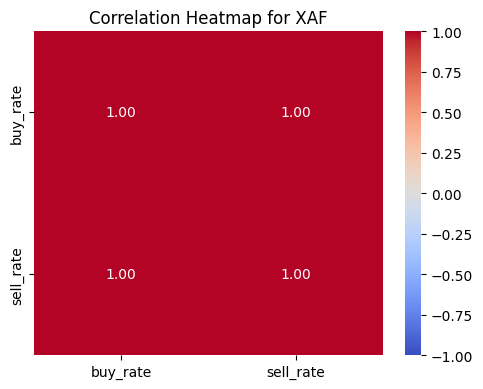

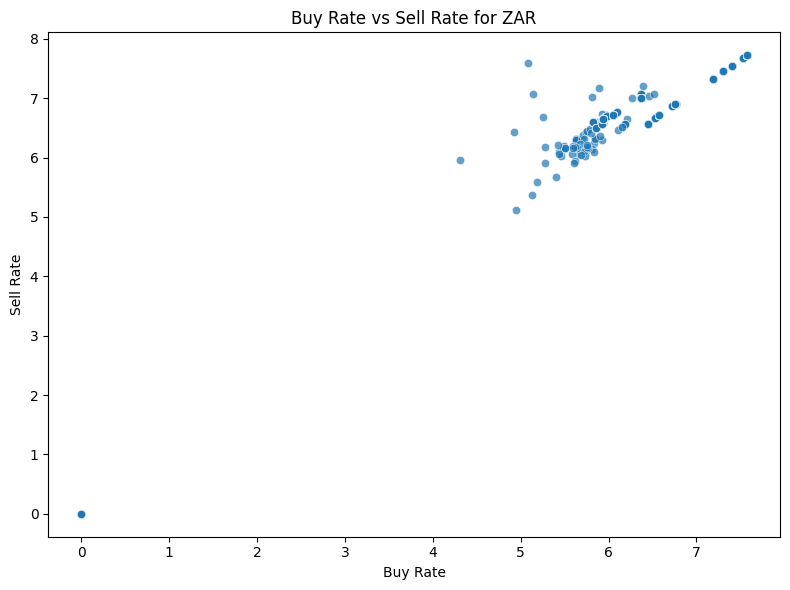


Correlation Matrix for ZAR:
           buy_rate  sell_rate
buy_rate   1.000000   0.968609
sell_rate  0.968609   1.000000


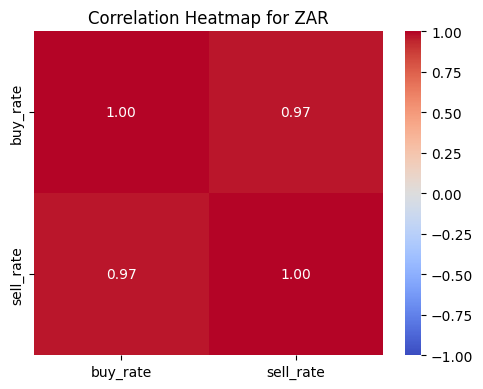

In [111]:
currency_list = df['currency_name'].unique()

for currency in currency_list:
        df_curr = df[df['currency_name'] == currency]
        
        # Scatter plot: buy_rate vs sell_rate for this currency
        plt.figure(figsize=(8,6))
        sns.scatterplot(data=df_curr, x='buy_rate', y='sell_rate', alpha=0.7)
        plt.title(f'Buy Rate vs Sell Rate for {currency}')
        plt.xlabel('Buy Rate')
        plt.ylabel('Sell Rate')
        plt.tight_layout()
        plt.show()
        
        # Correlation matrix for buy_rate and sell_rate
        corr_matrix = df_curr[['buy_rate', 'sell_rate']].corr()
        print(f"\nCorrelation Matrix for {currency}:")
        print(corr_matrix)
        
        plt.figure(figsize=(5,4))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
        plt.title(f'Correlation Heatmap for {currency}')
        plt.tight_layout()
        plt.show()

In [113]:
# time series analysis 

# time summary 
print("Data Range:", df.index.min(), "to", df.index.max())
print("Counts per day: ", df.resample('D').size().head())


Data Range: 2024-07-23 00:00:00+00:00 to 2025-08-11 07:20:43.303962+00:00
Counts per day:  created_at
2024-07-23 00:00:00+00:00    25
2024-07-24 00:00:00+00:00    25
2024-07-25 00:00:00+00:00    25
2024-07-26 00:00:00+00:00    25
2024-07-27 00:00:00+00:00     0
Freq: D, dtype: int64


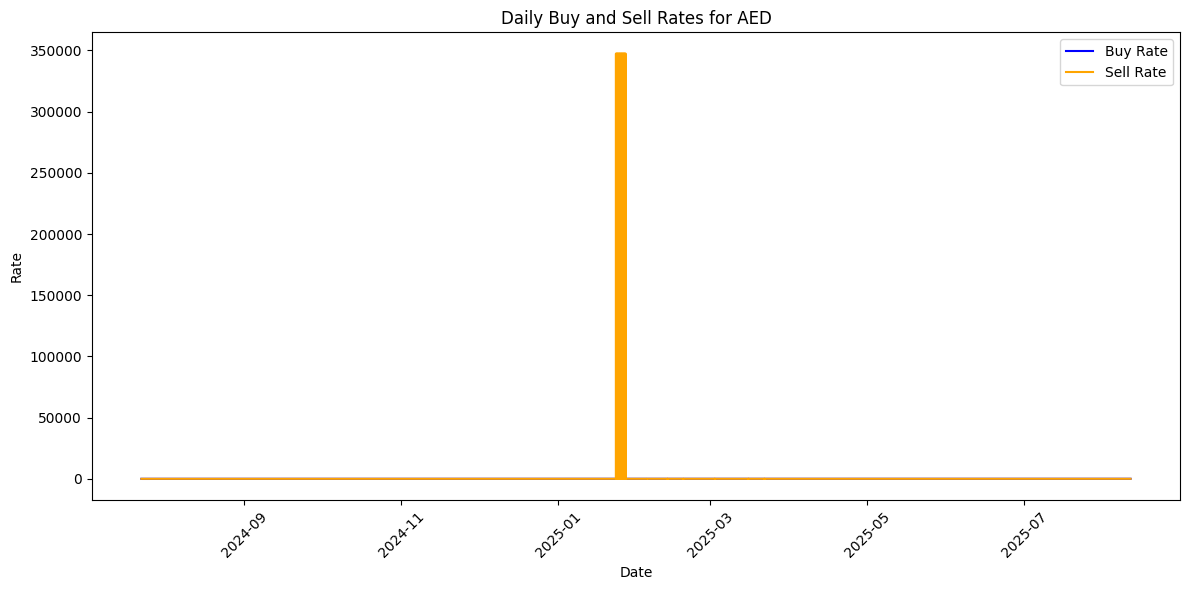

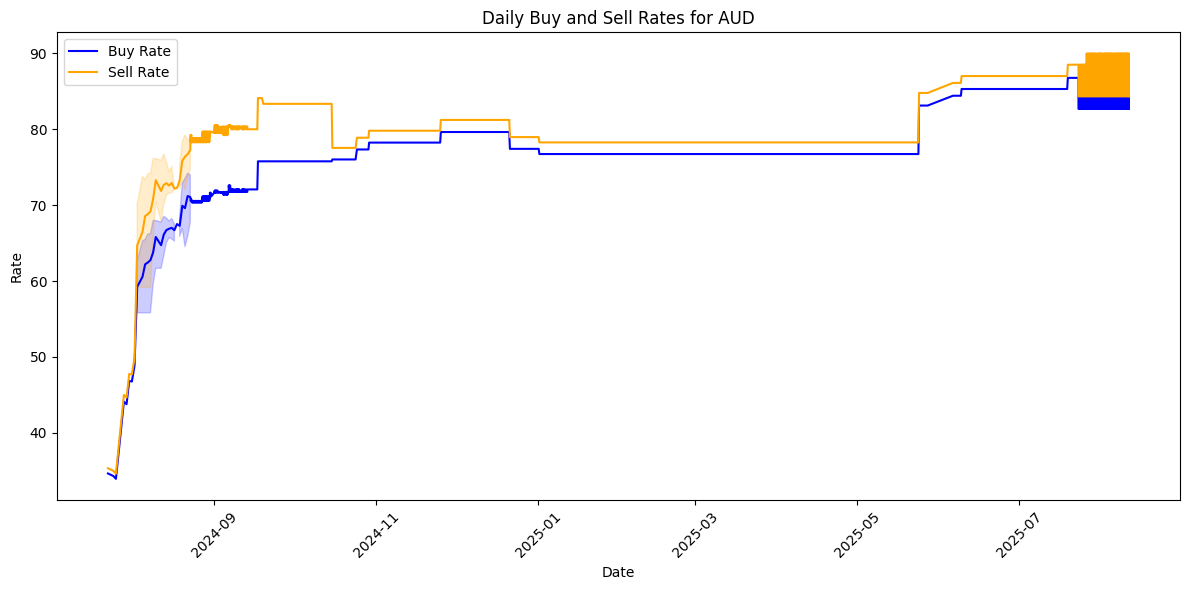

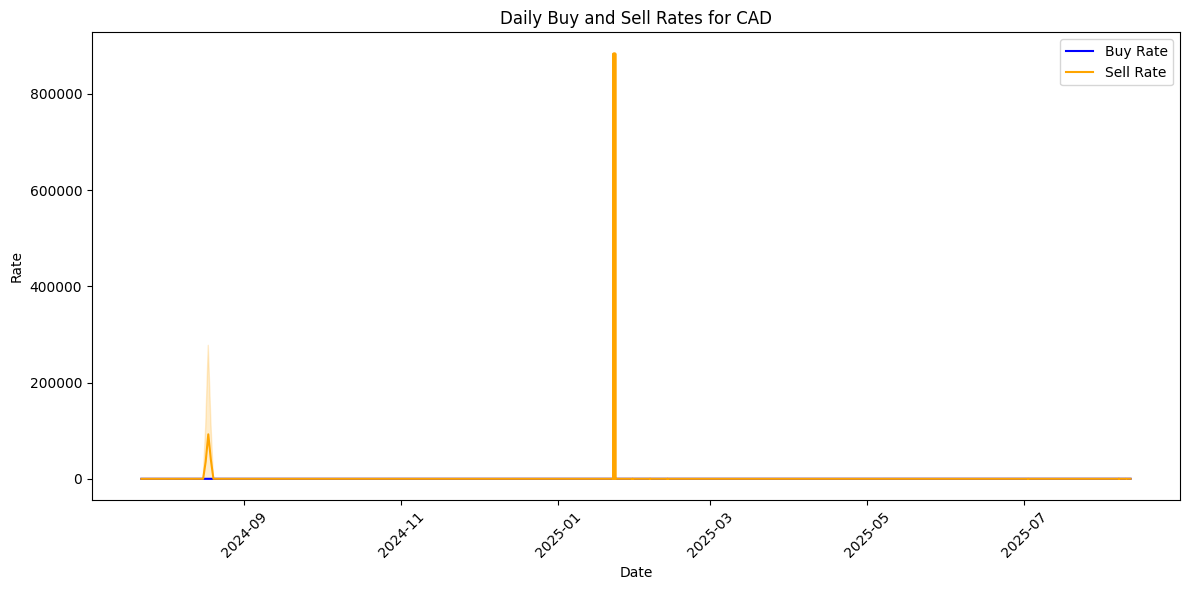

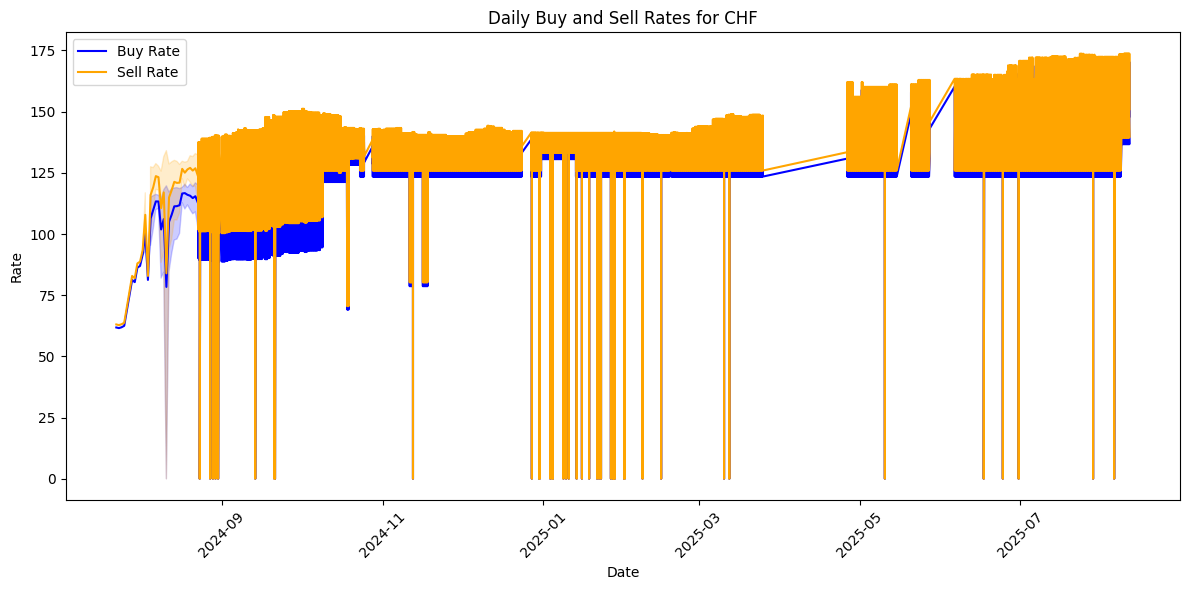

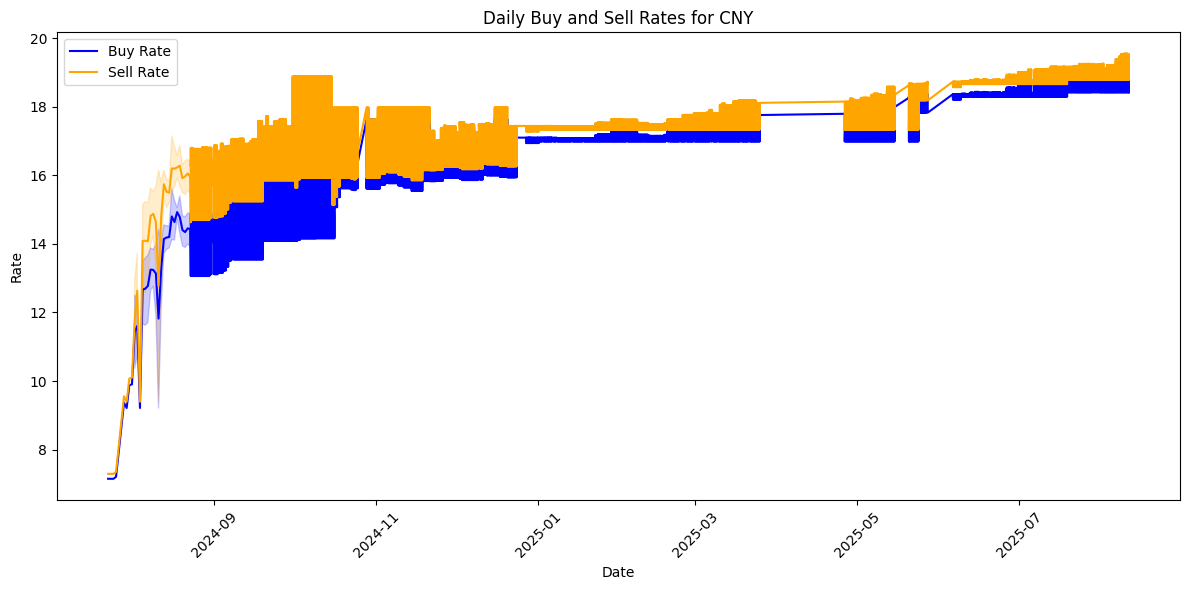

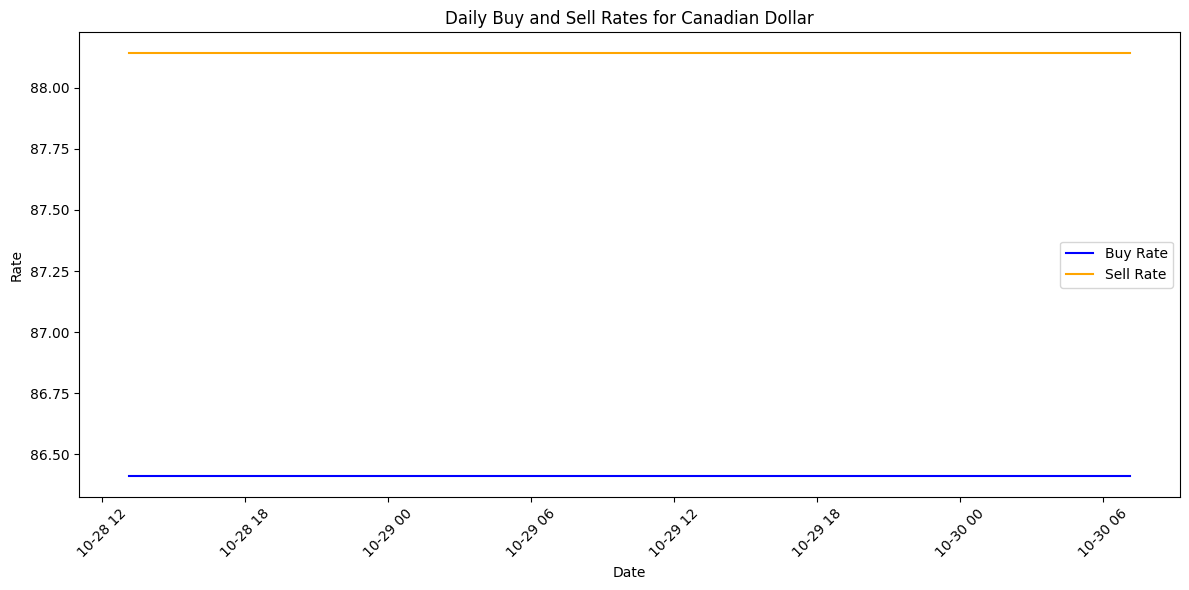

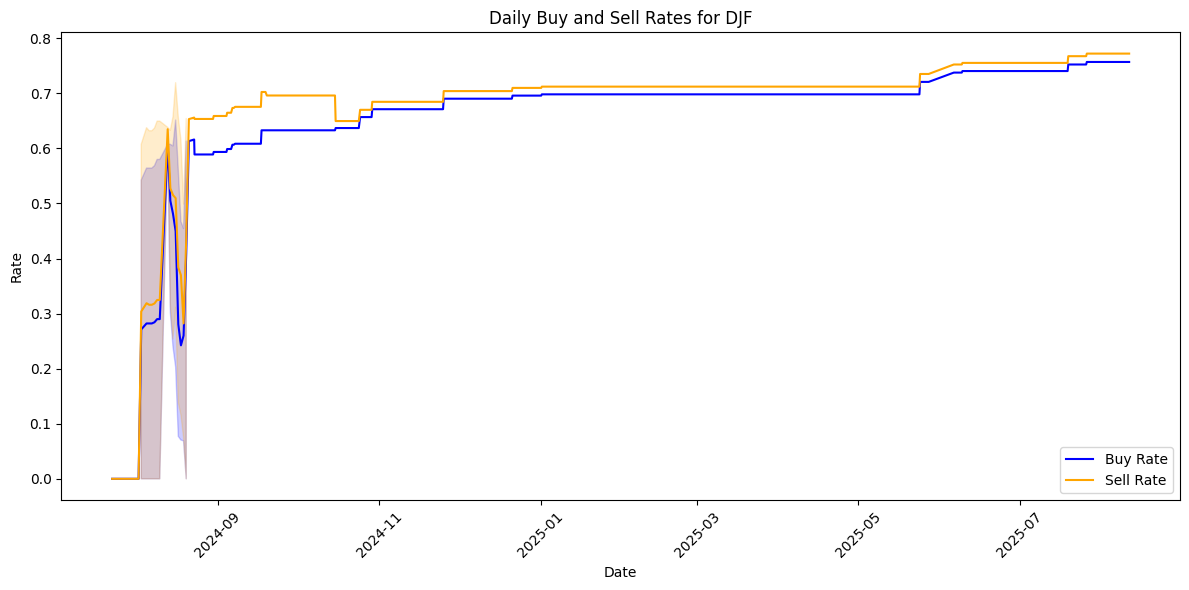

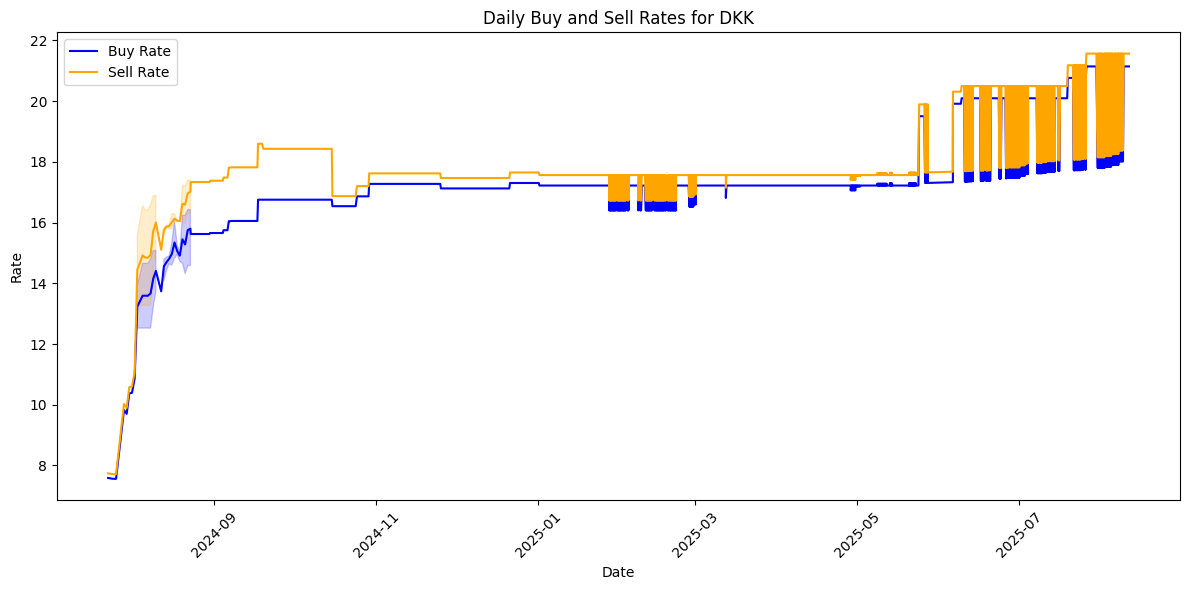

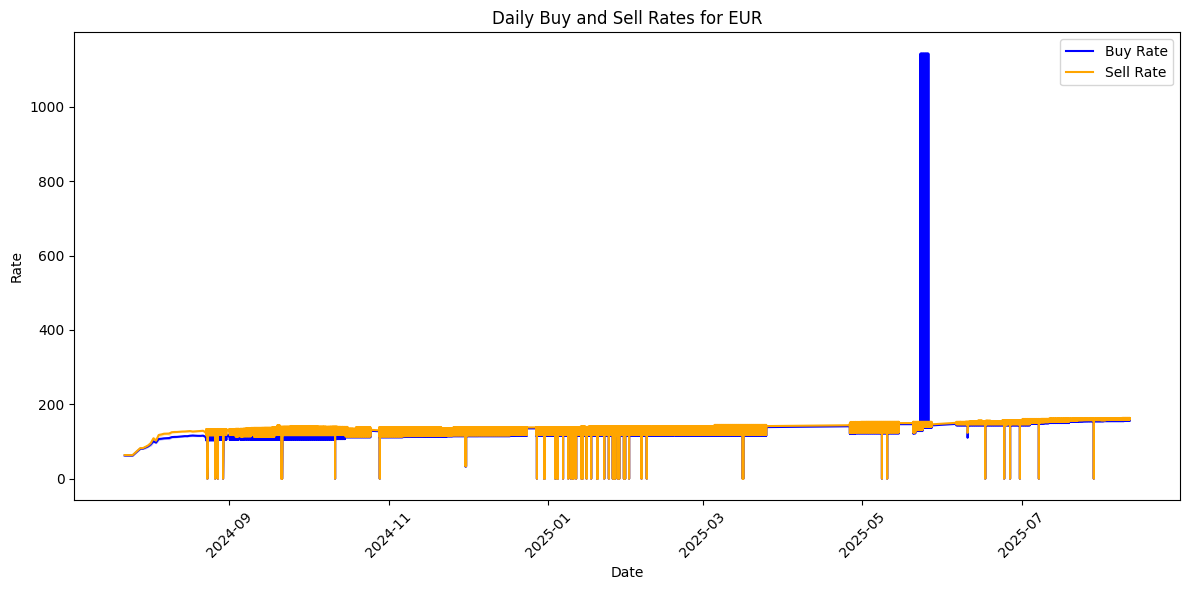

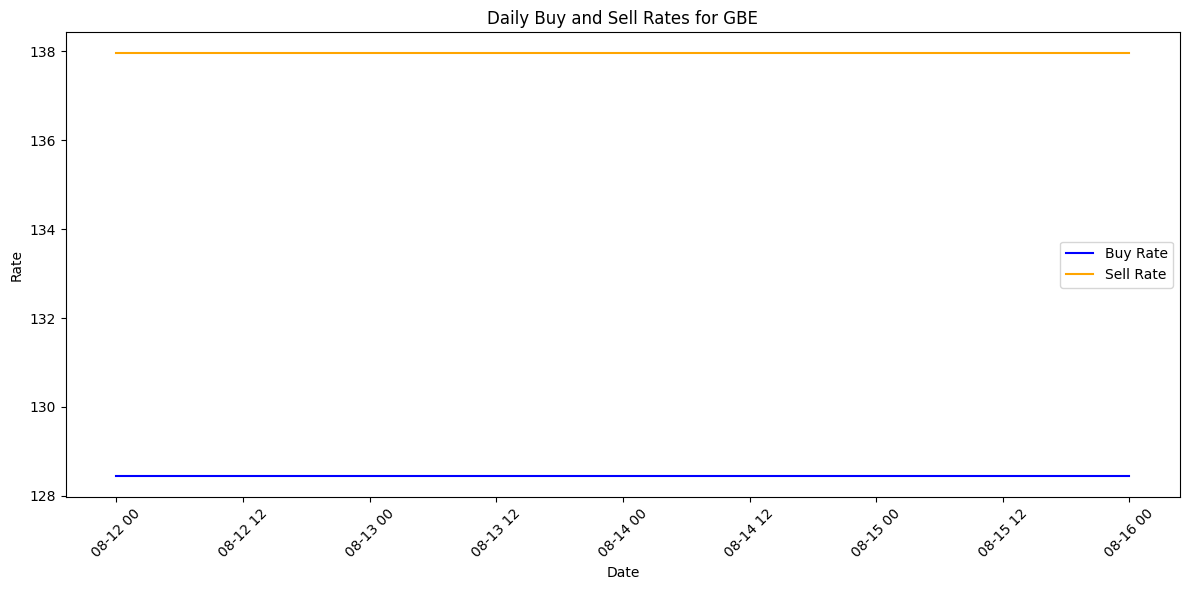

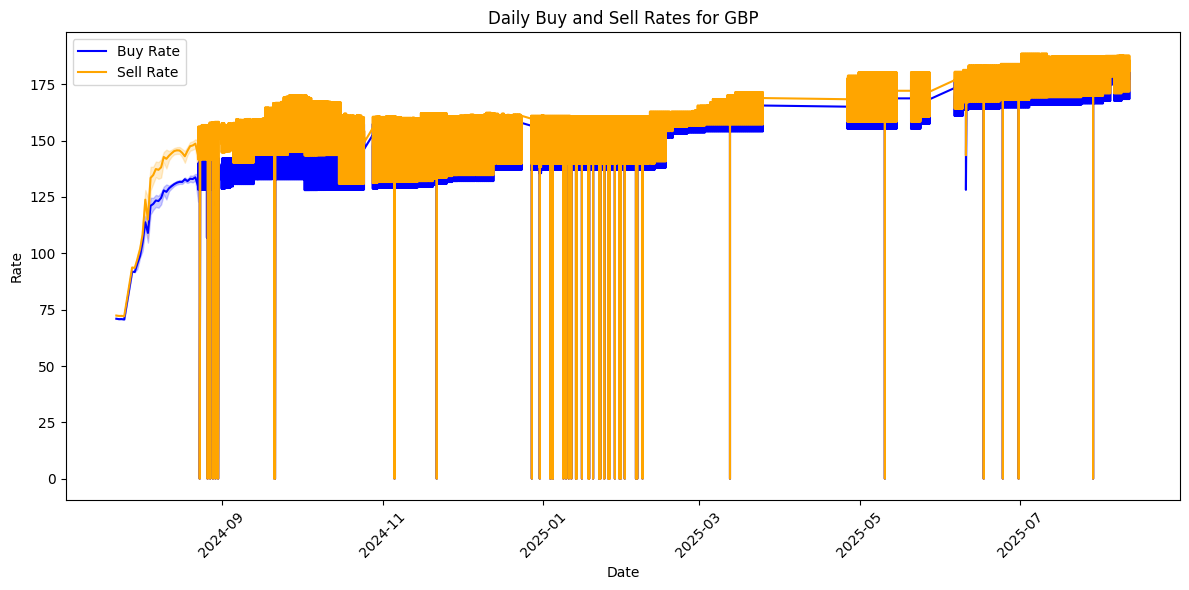

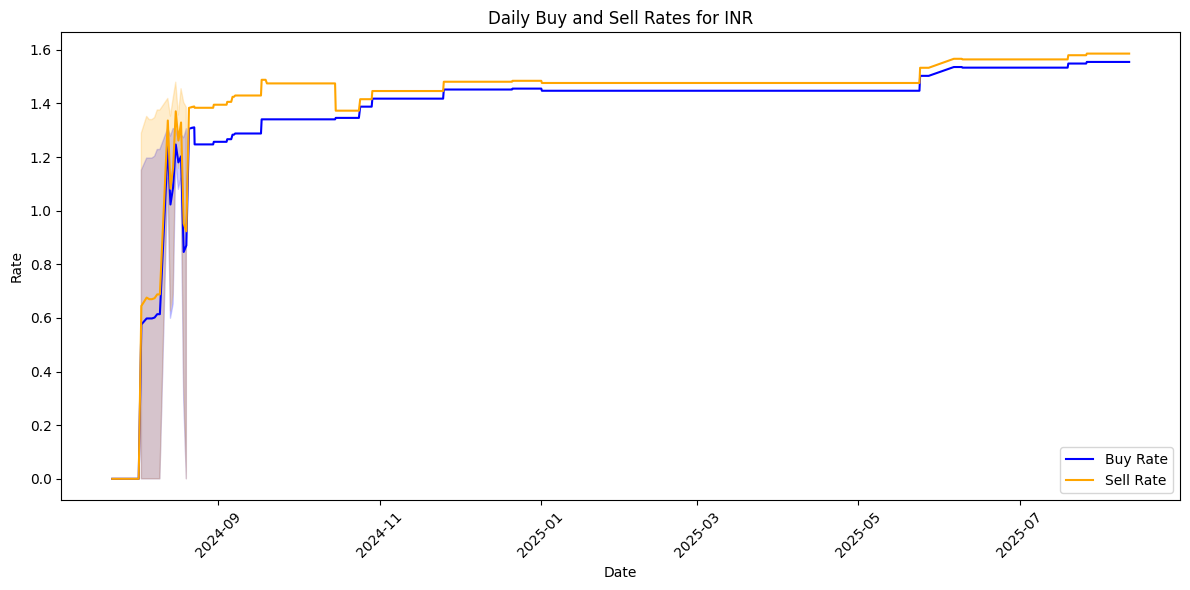

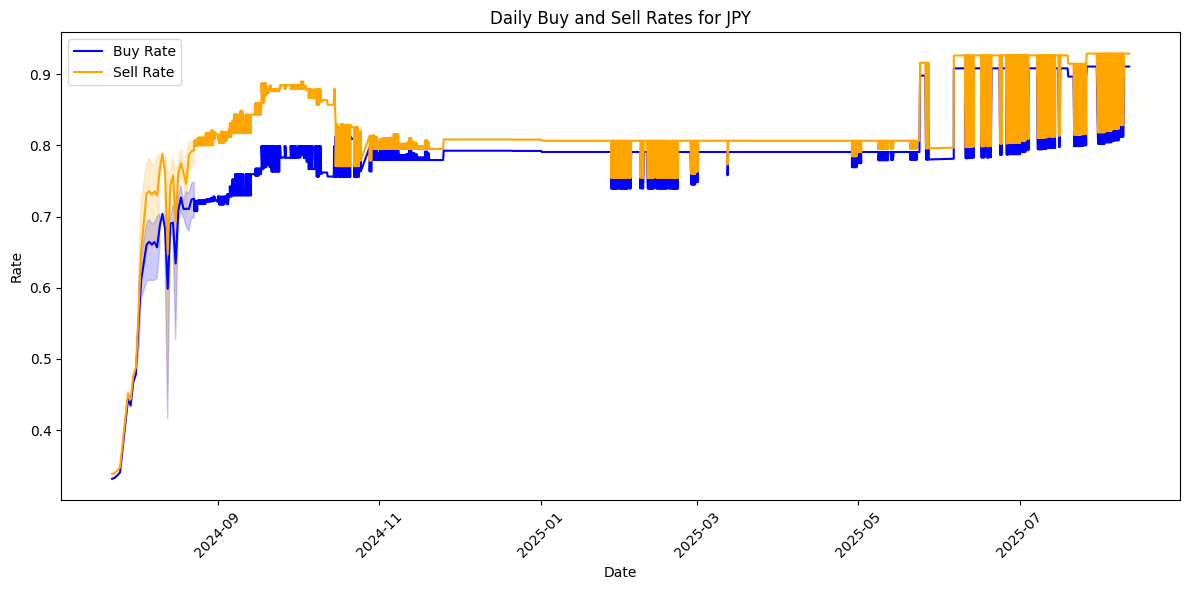

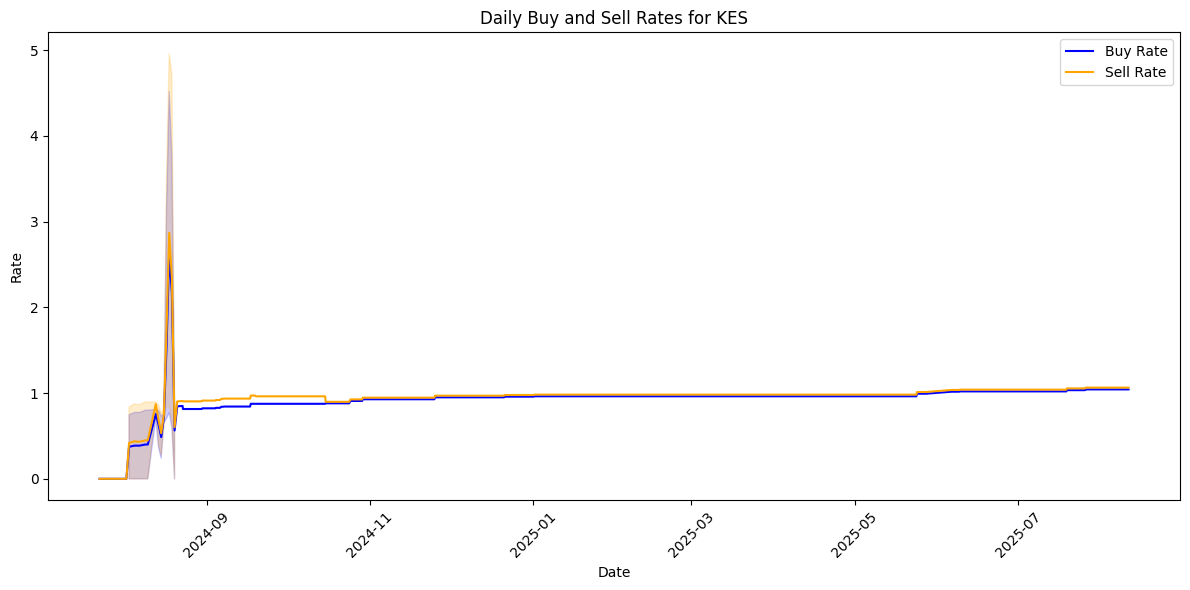

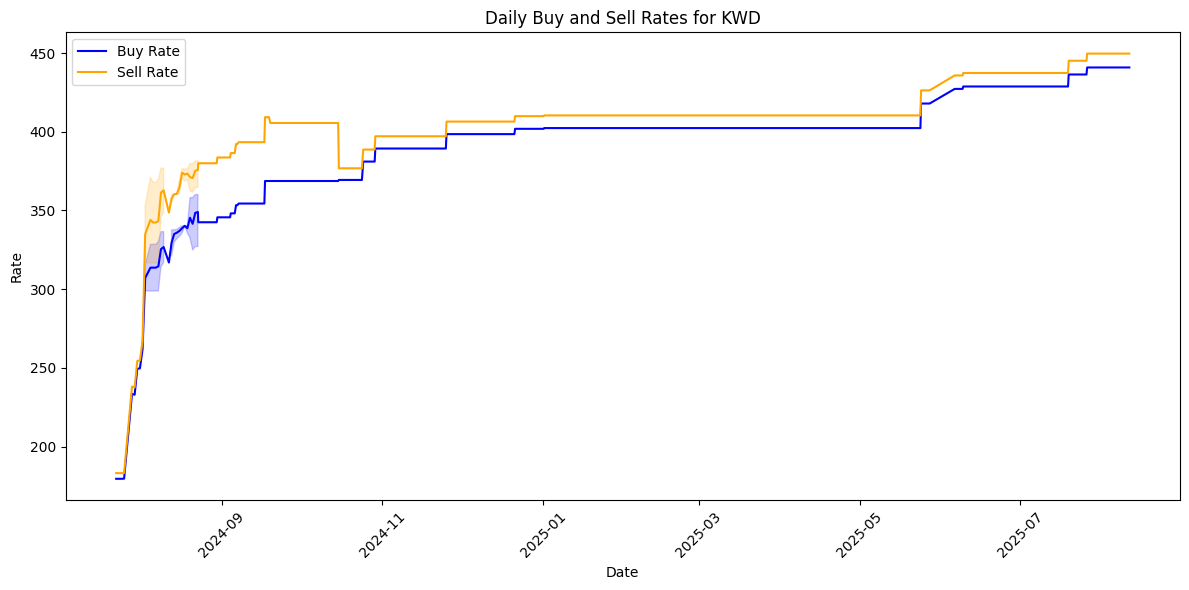

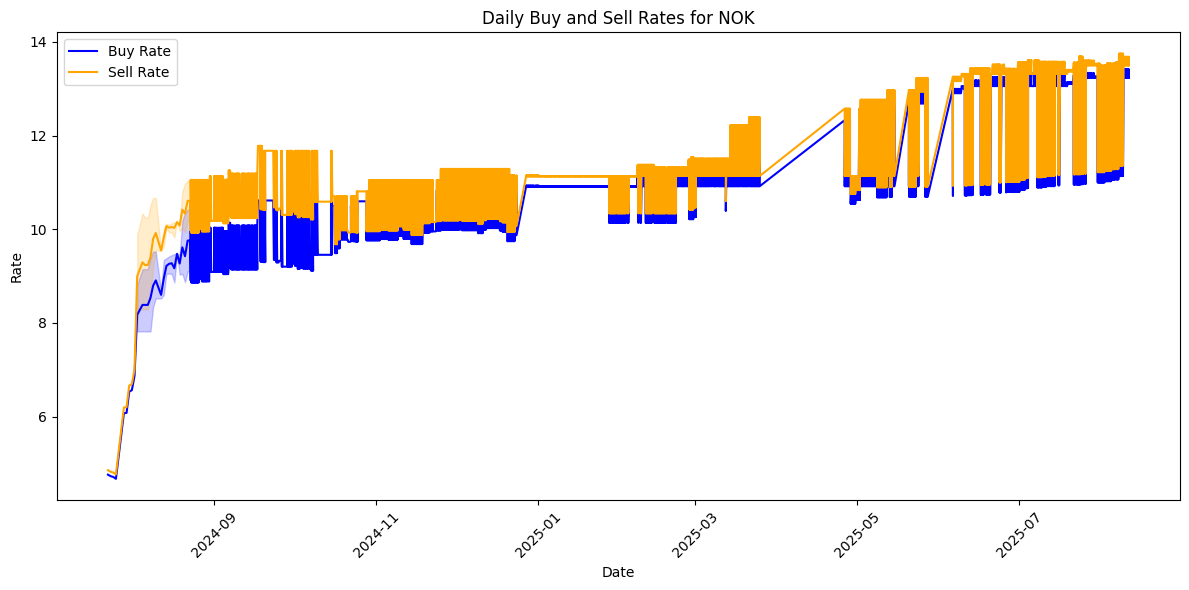

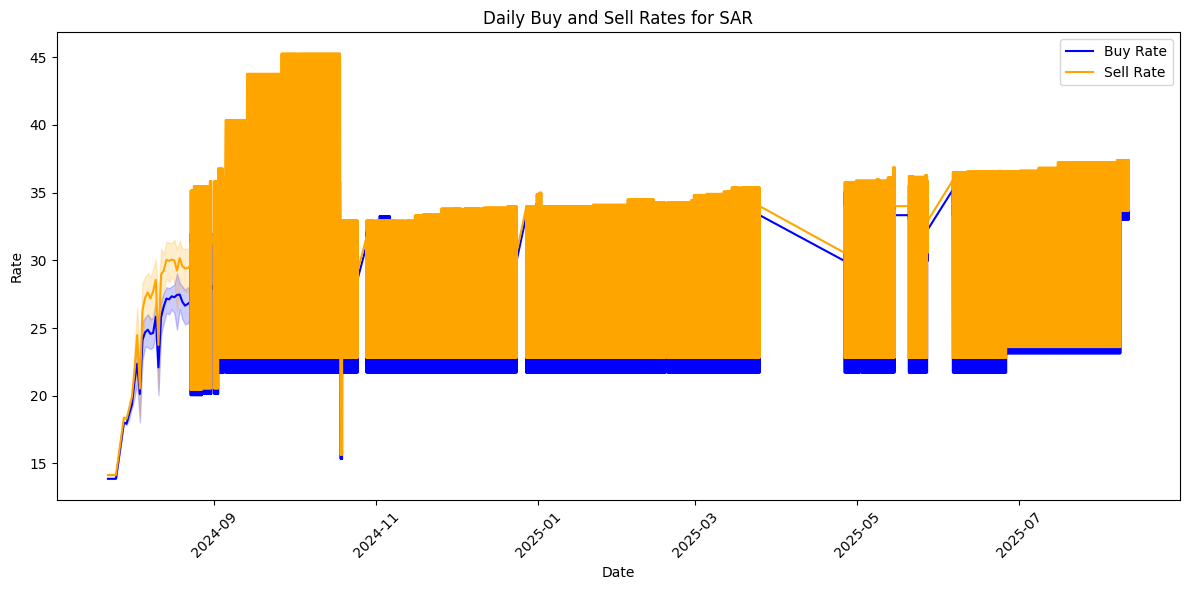

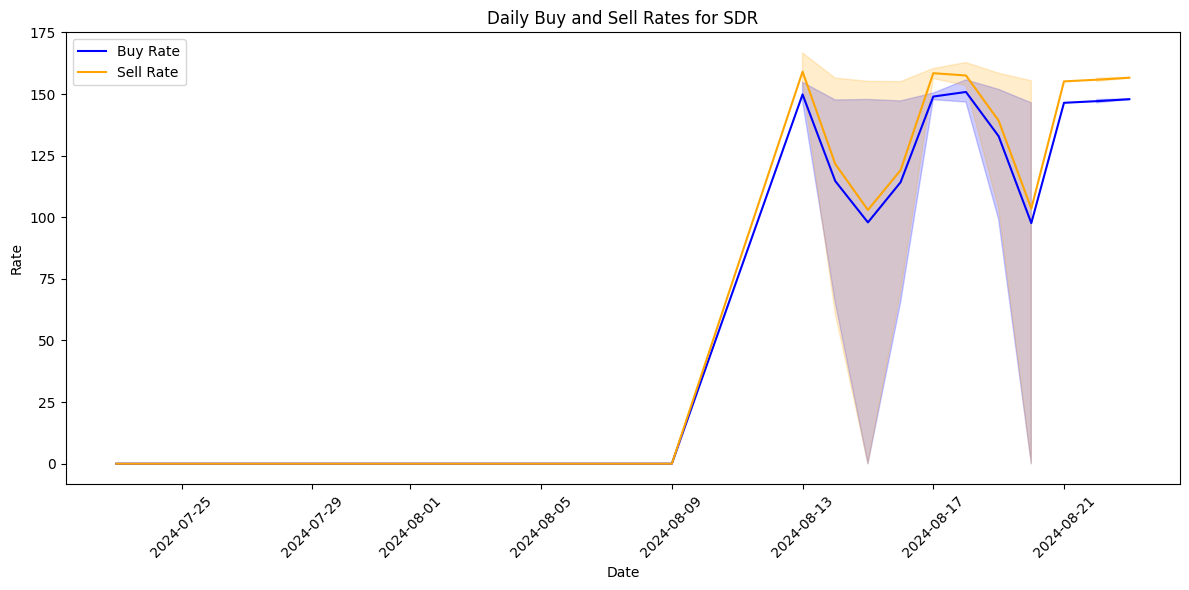

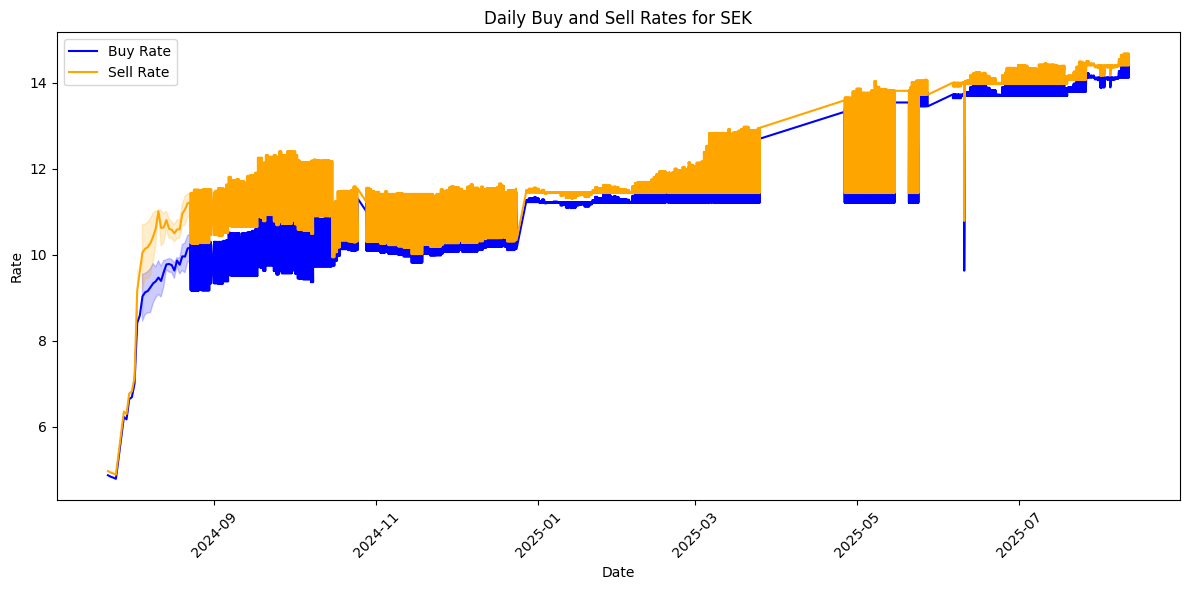

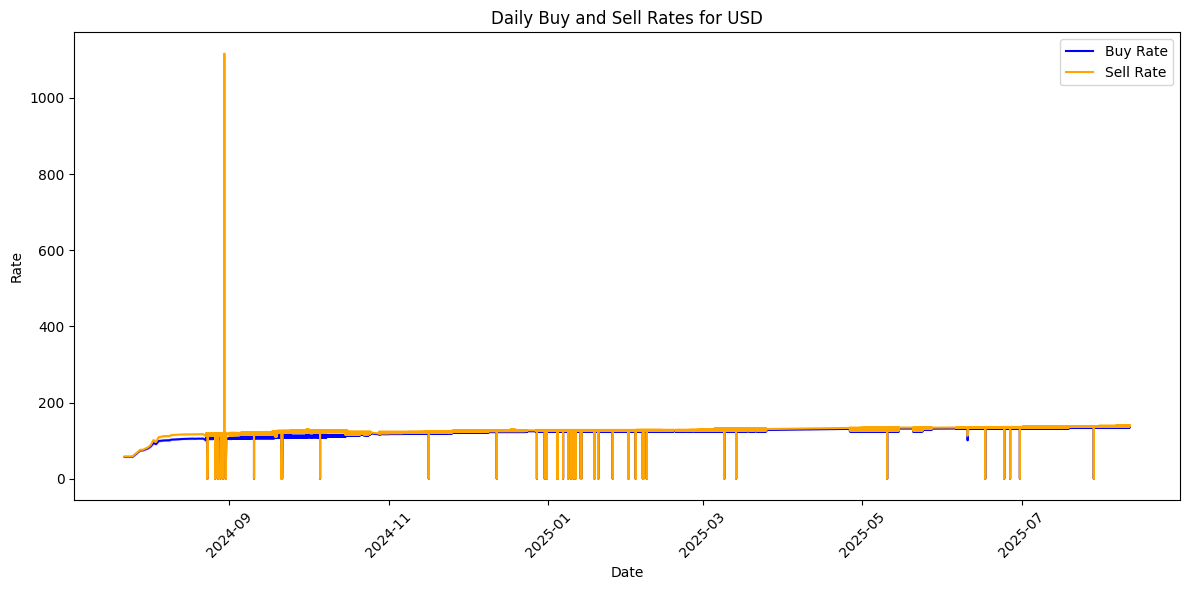

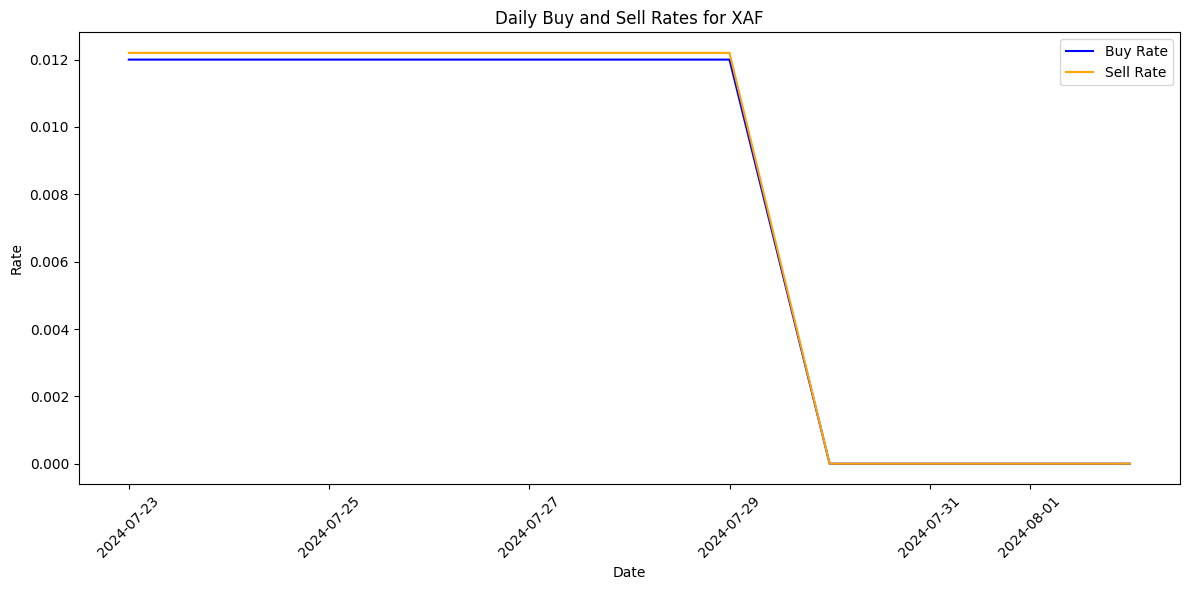

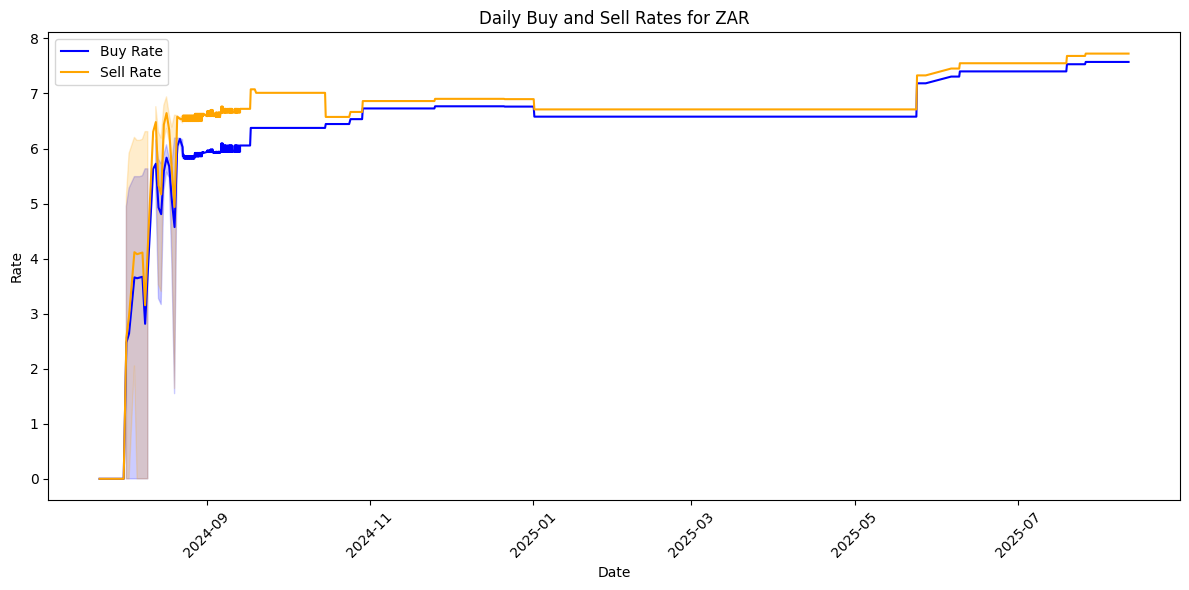

In [114]:
# time series analysis - daily average buy_rate and sell_rate


currency_list = df['currency_name'].unique()

for currency in currency_list:
    df_currency = df[df['currency_name'] == currency]
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_currency, x='created_at', y='buy_rate', label='Buy Rate', color='blue')
    sns.lineplot(data=df_currency, x='created_at', y='sell_rate', label='Sell Rate', color='orange')
    plt.title(f'Daily Buy and Sell Rates for {currency}')
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [117]:
# daily averages per currency,

# Group by currency, then resample daily and calculate mean
daily_avg_per_currency = (
    df.groupby('currency_name')
      .resample('D')
      .mean(numeric_only=True)
      .reset_index()
)

print("\nDaily Average Buy Rate and Sell Rate per Currency:")
daily_avg_per_currency[['currency_name', 'created_at', 'buy_rate', 'sell_rate']].to_csv("./daily_avg_per_currency.csv", index=False)
print(daily_avg_per_currency.head())



Daily Average Buy Rate and Sell Rate per Currency:
  currency_name                created_at       id  buy_rate  sell_rate
0           AED 2024-07-23 00:00:00+00:00  10072.5   14.1591    14.4423
1           AED 2024-07-24 00:00:00+00:00  10097.5   14.1604    14.4436
2           AED 2024-07-25 00:00:00+00:00  10122.5   14.1632    14.4465
3           AED 2024-07-26 00:00:00+00:00  10147.5   14.1646    14.4479
4           AED 2024-07-27 00:00:00+00:00      NaN       NaN        NaN


/tmp/ipykernel_386851/1278189303.py:7: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


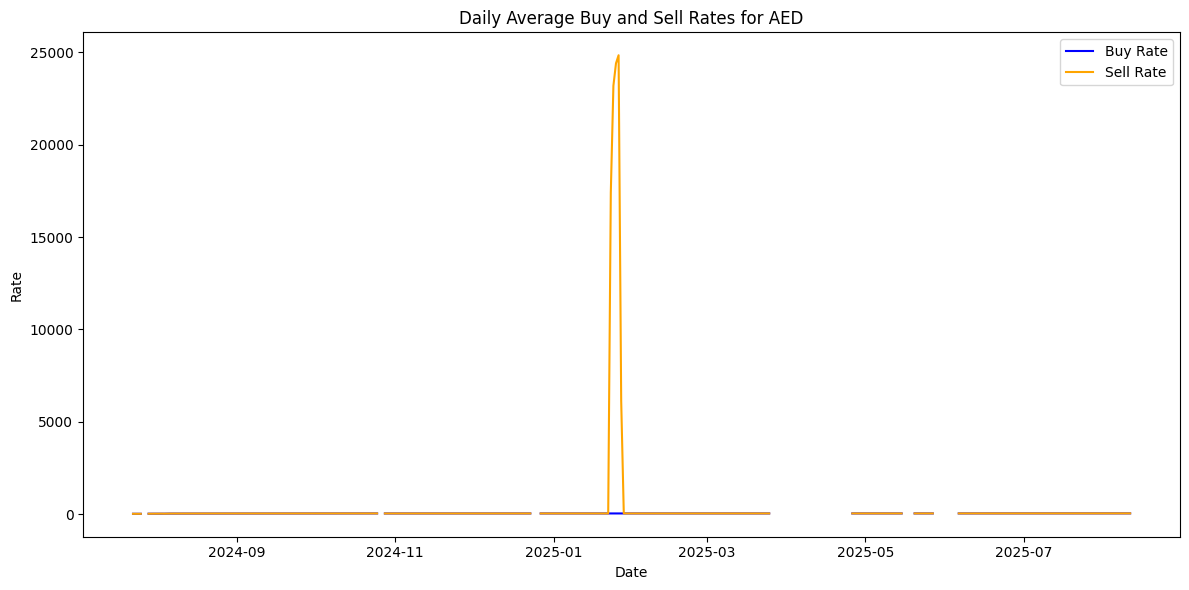

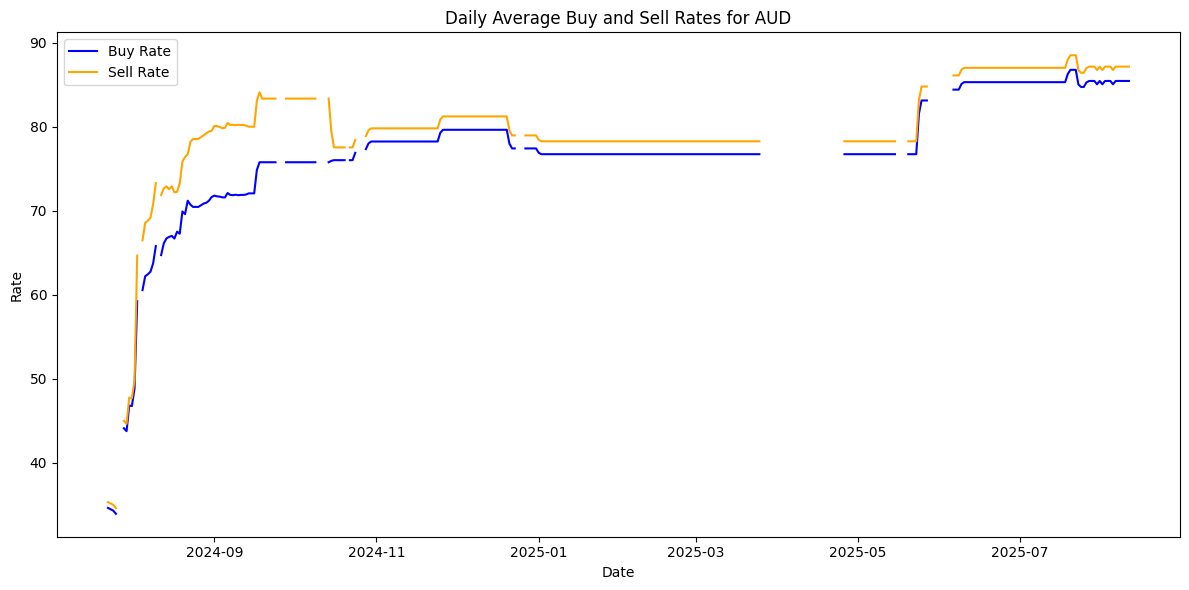

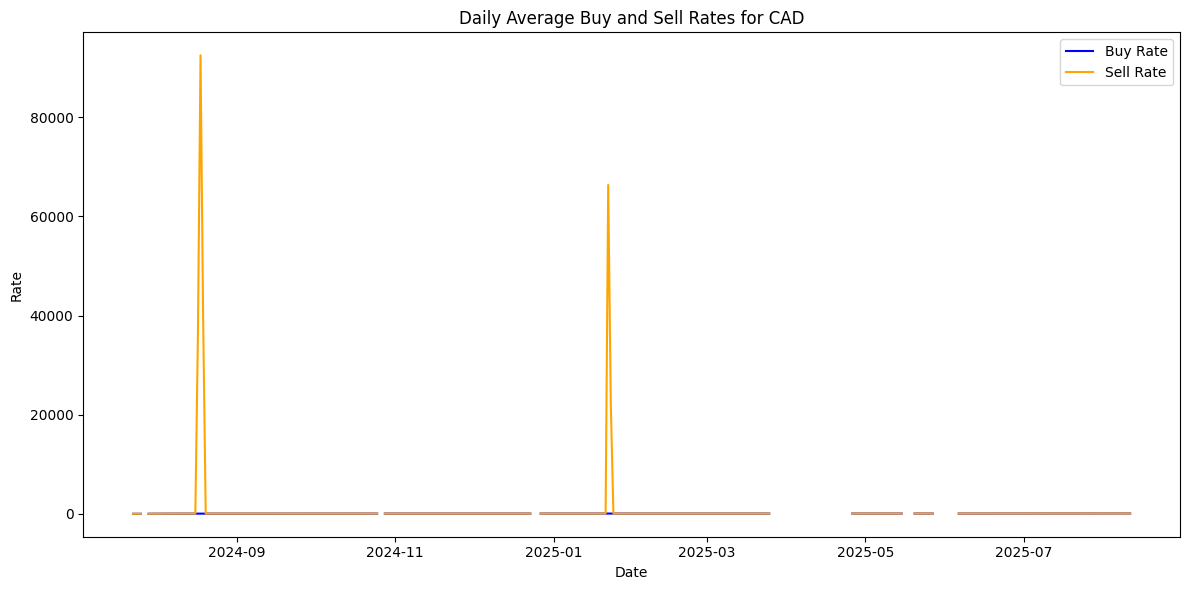

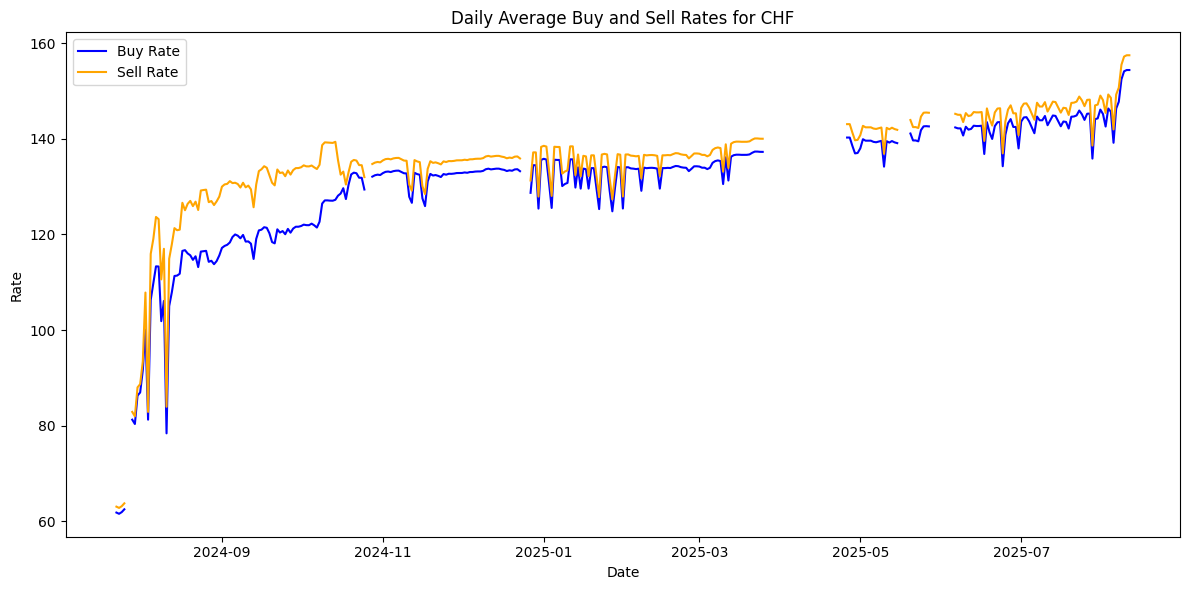

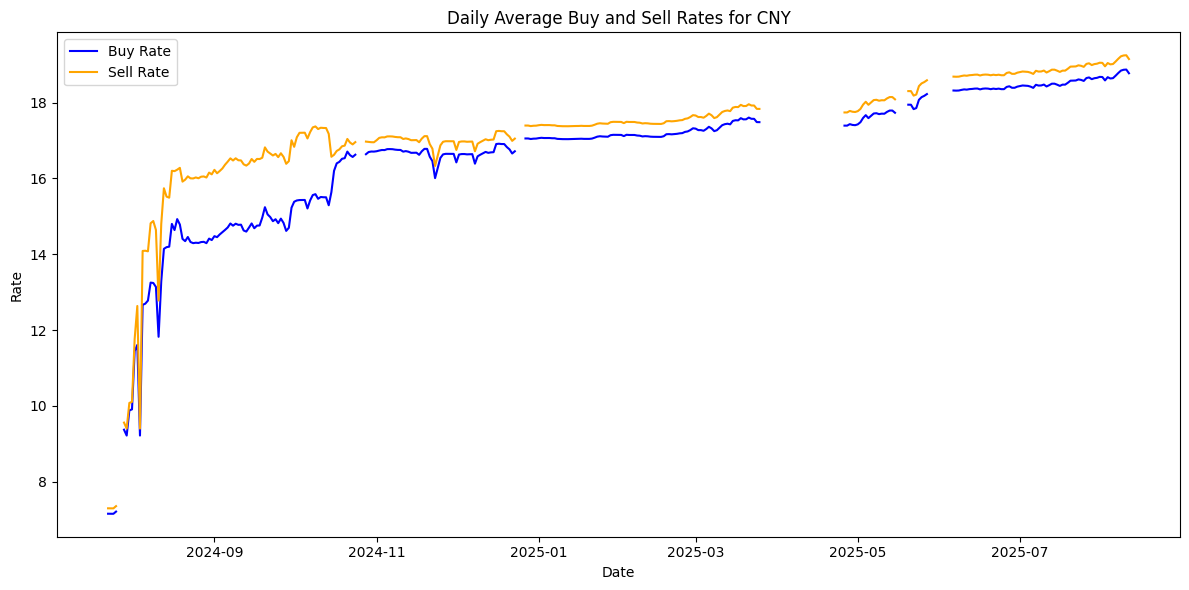

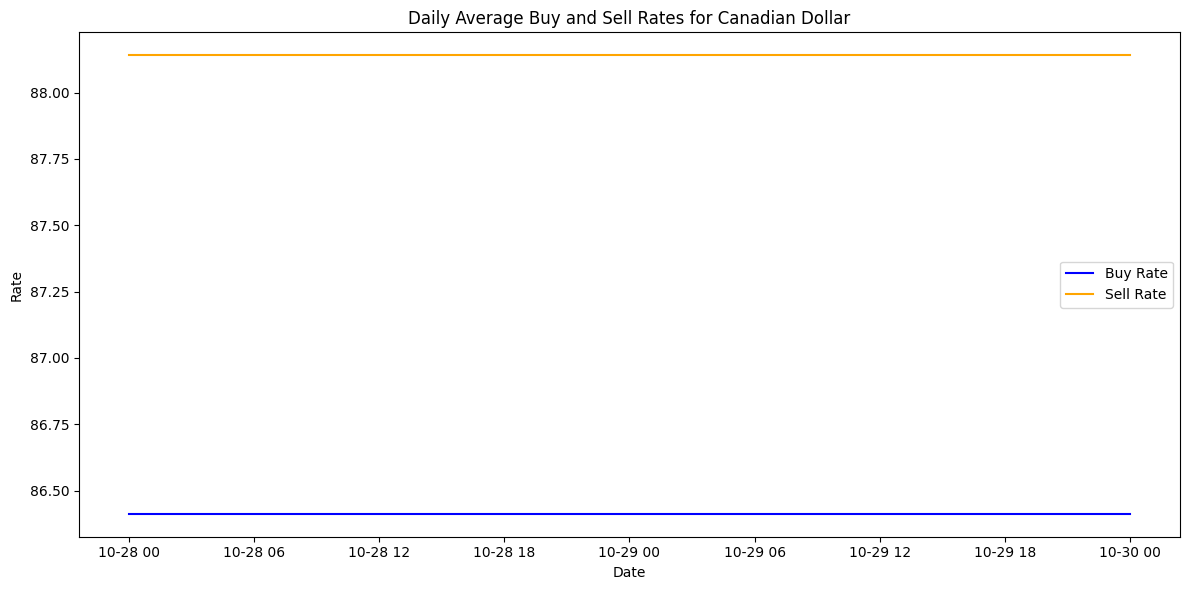

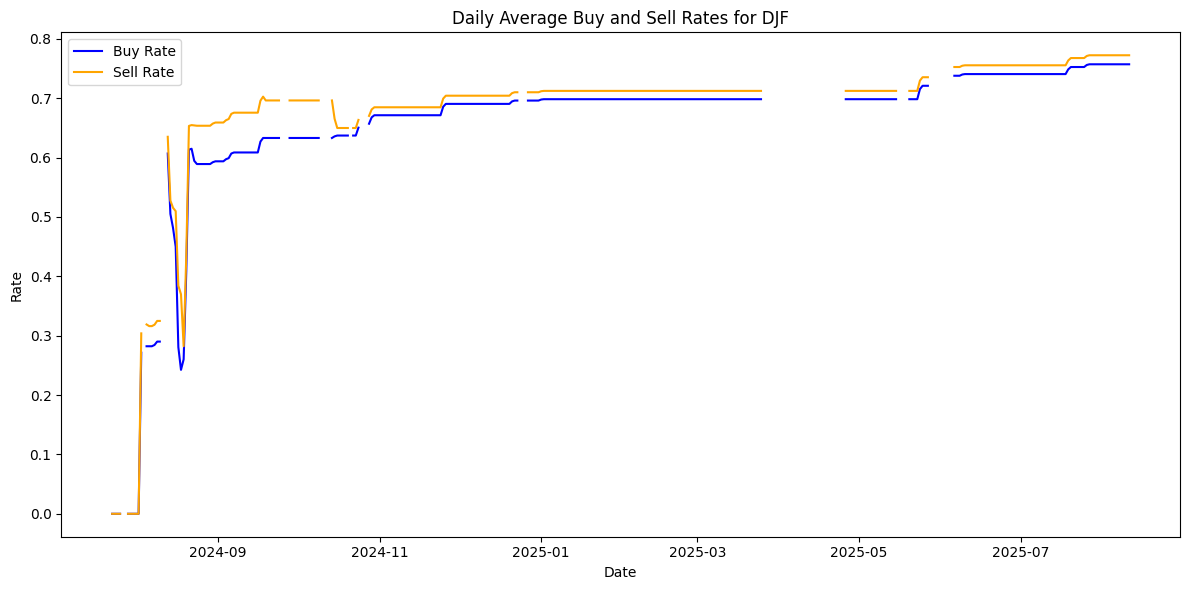

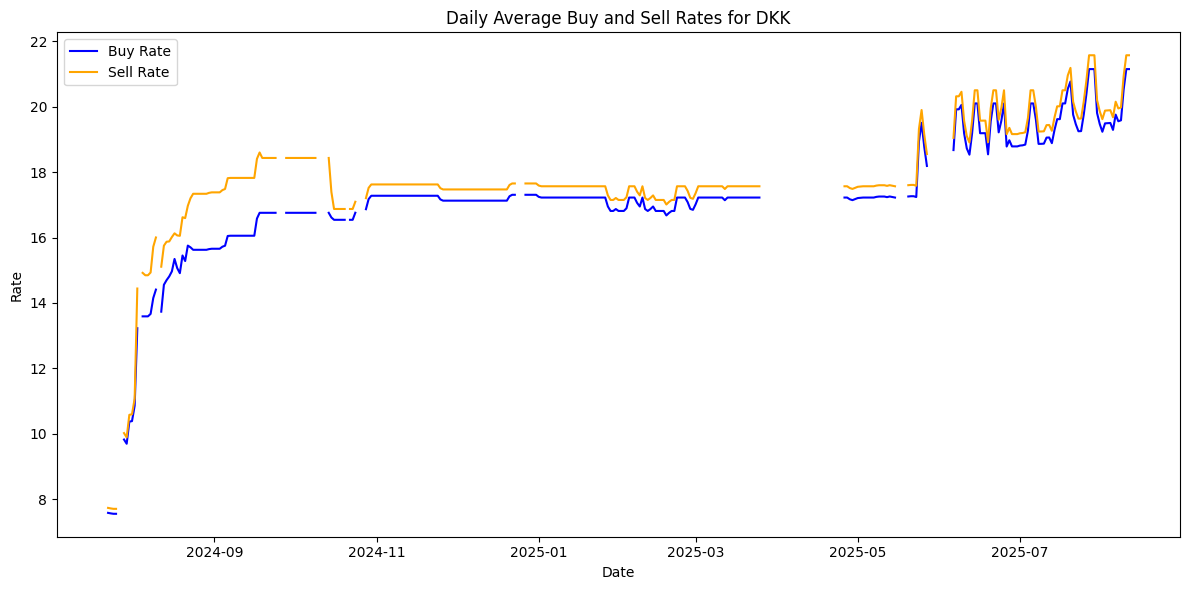

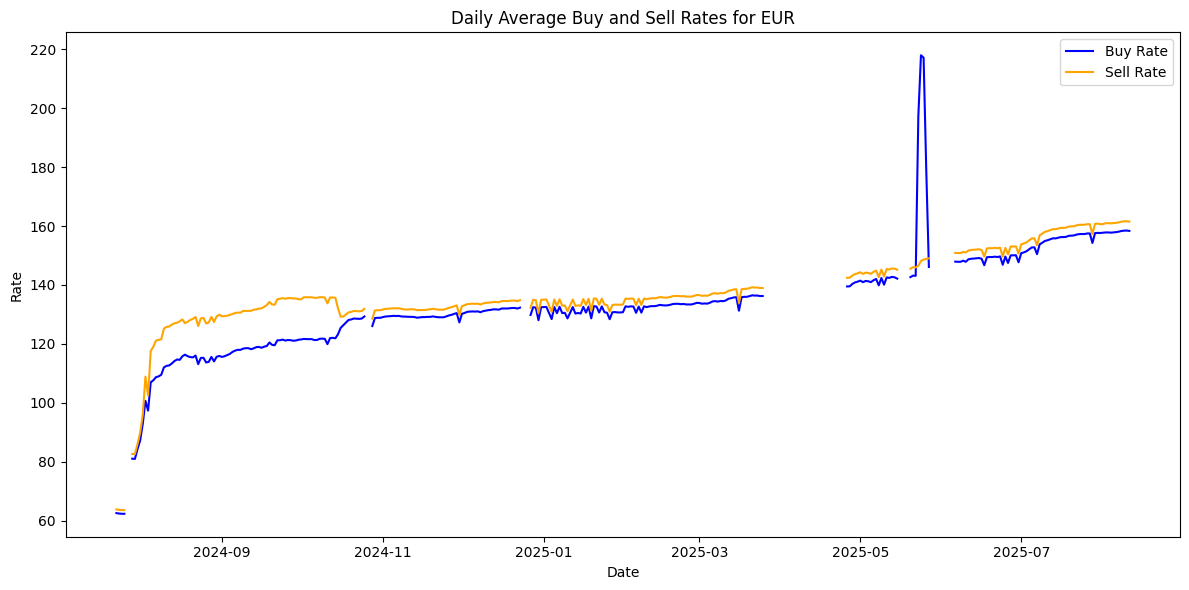

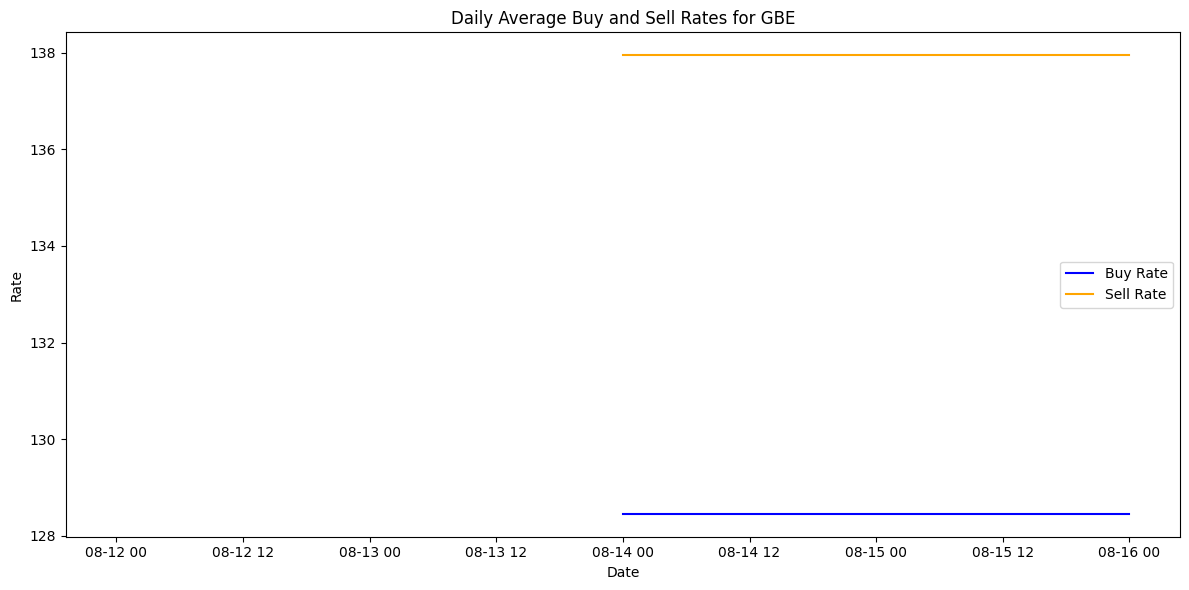

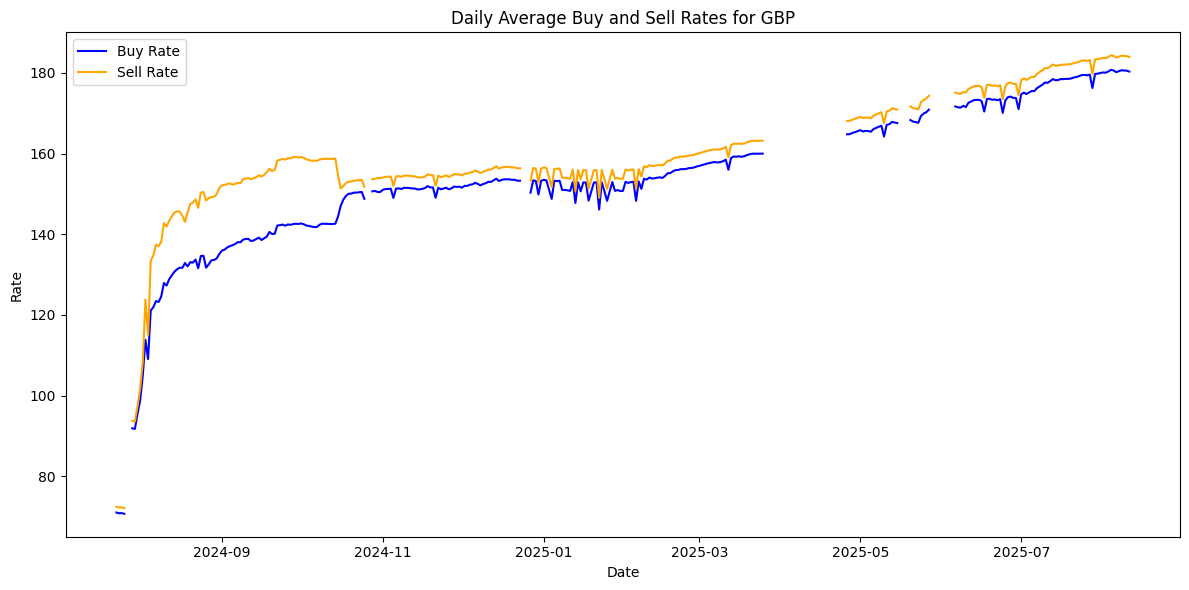

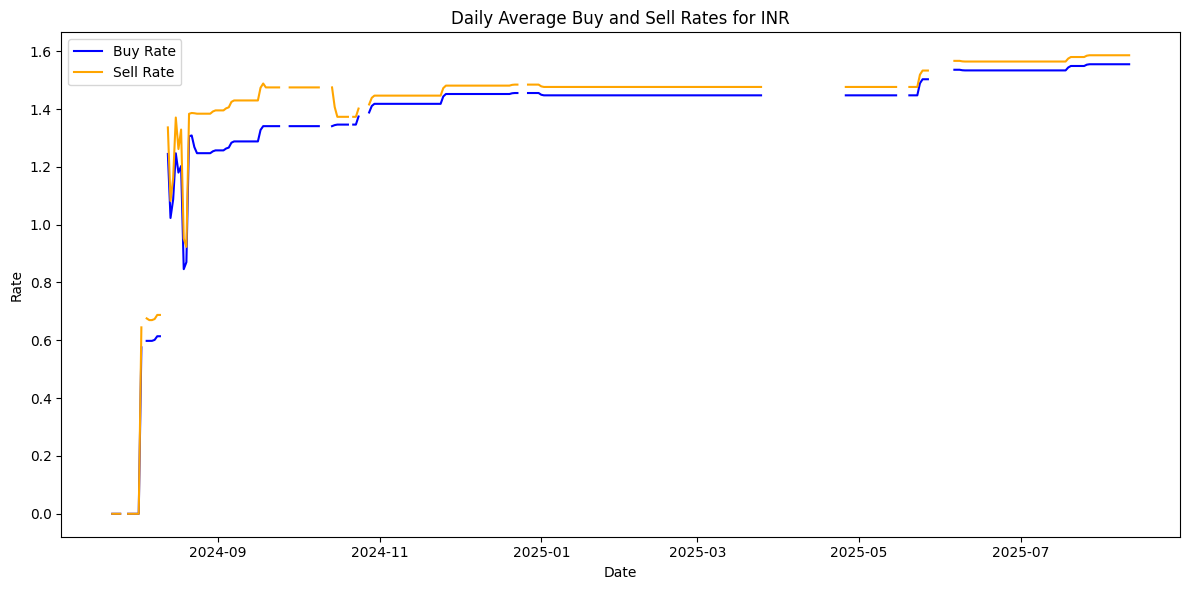

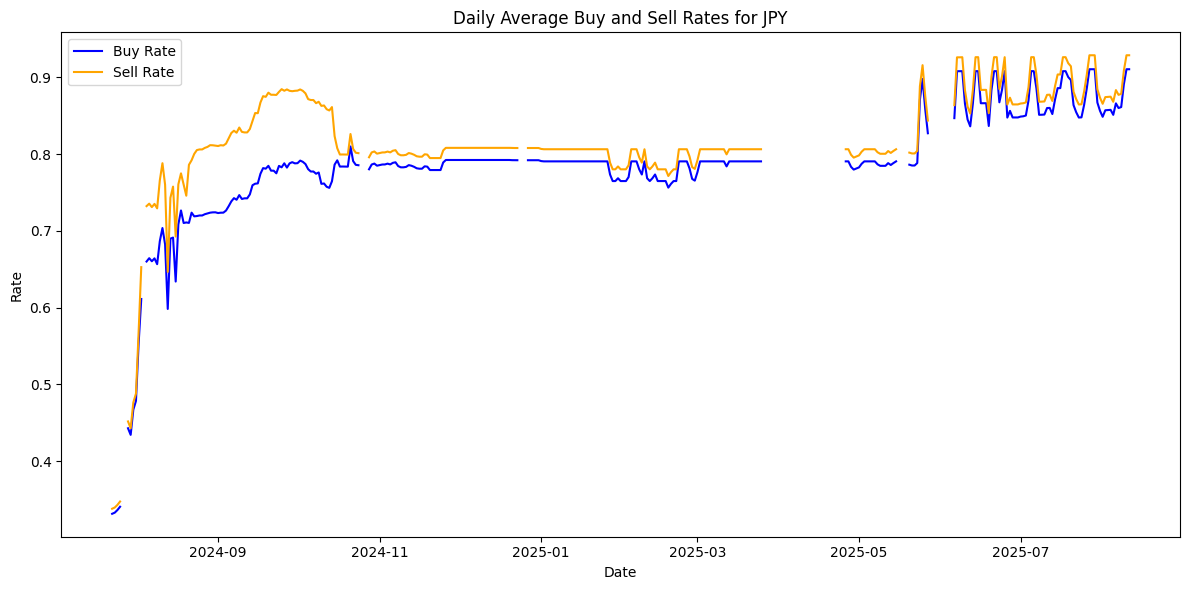

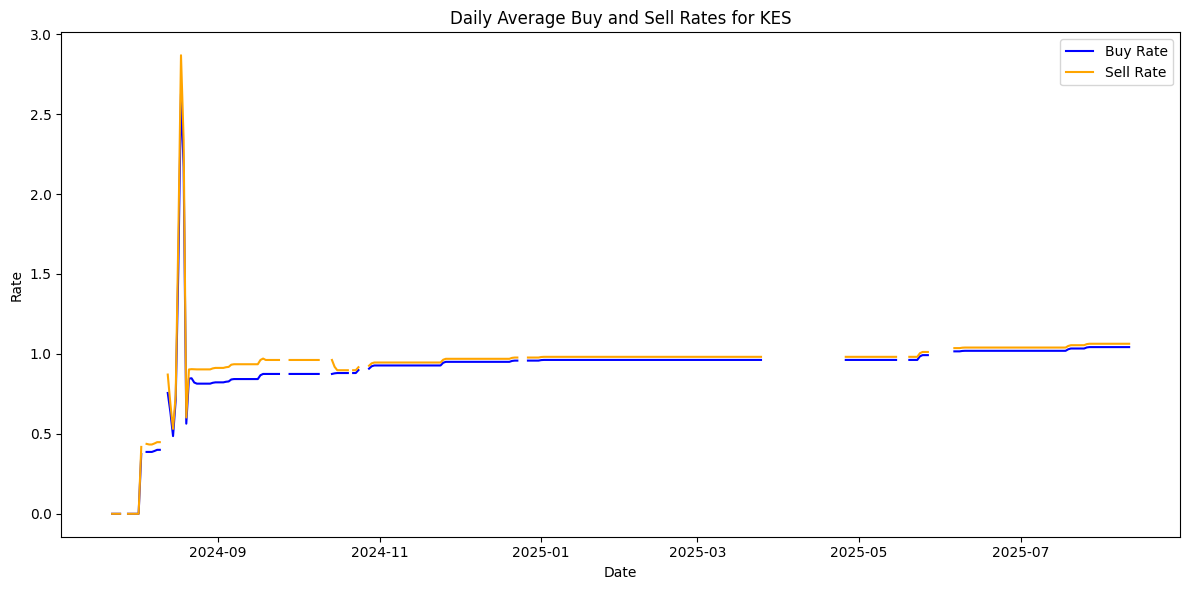

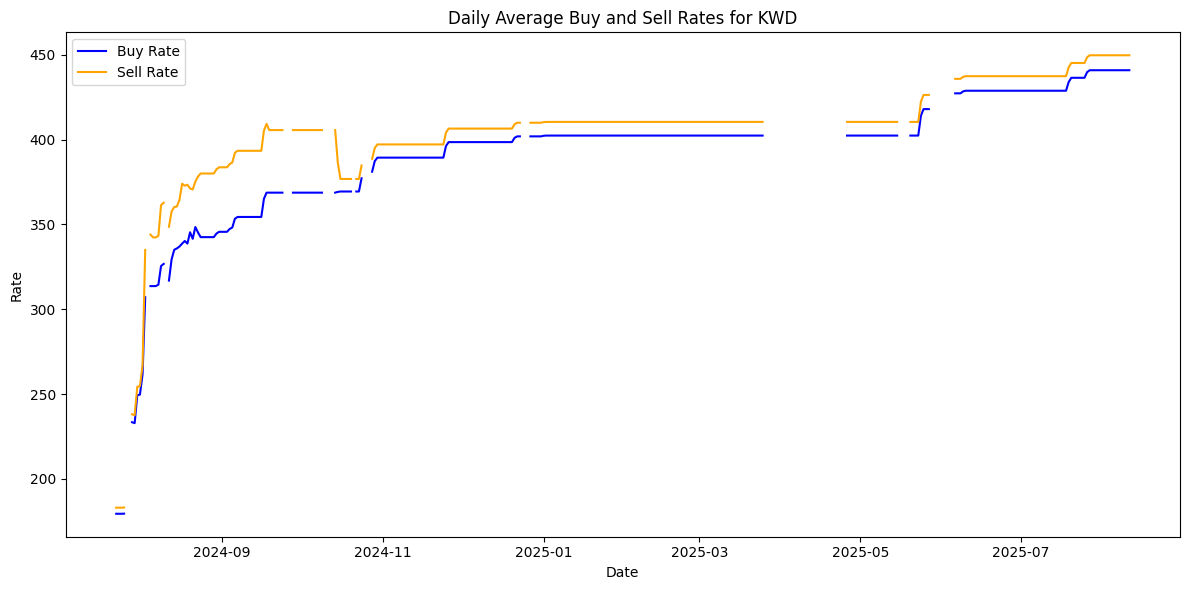

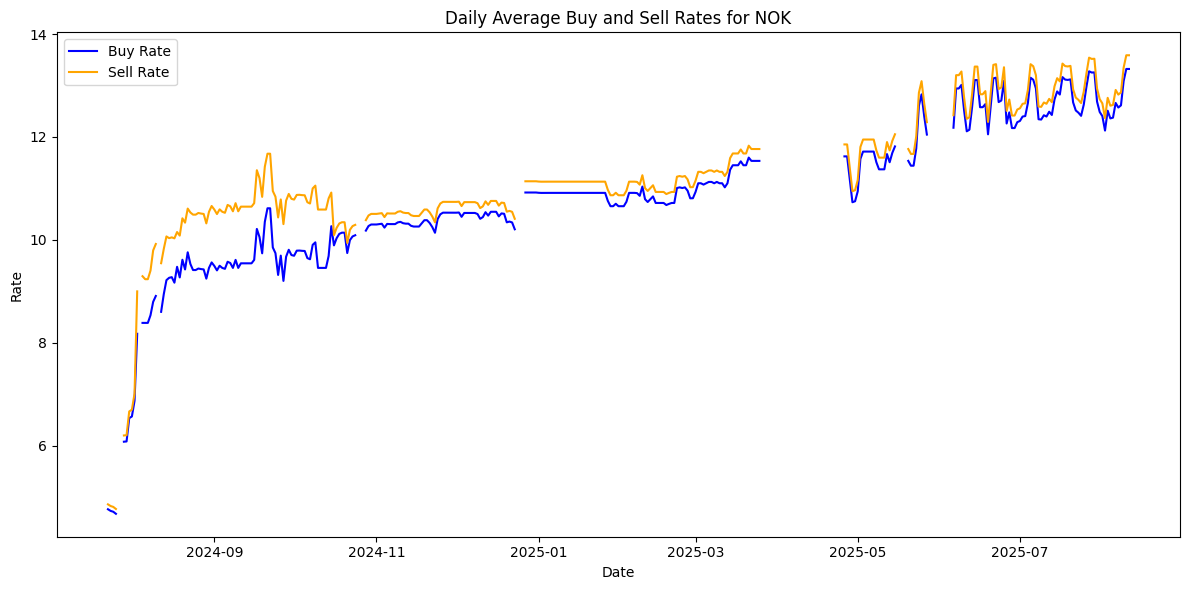

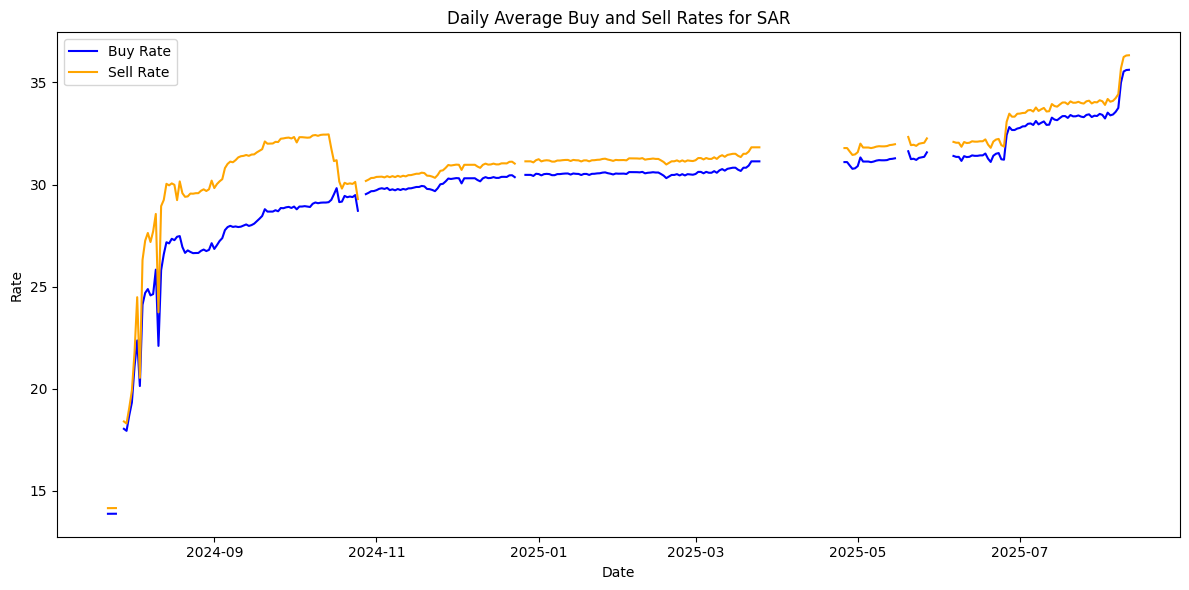

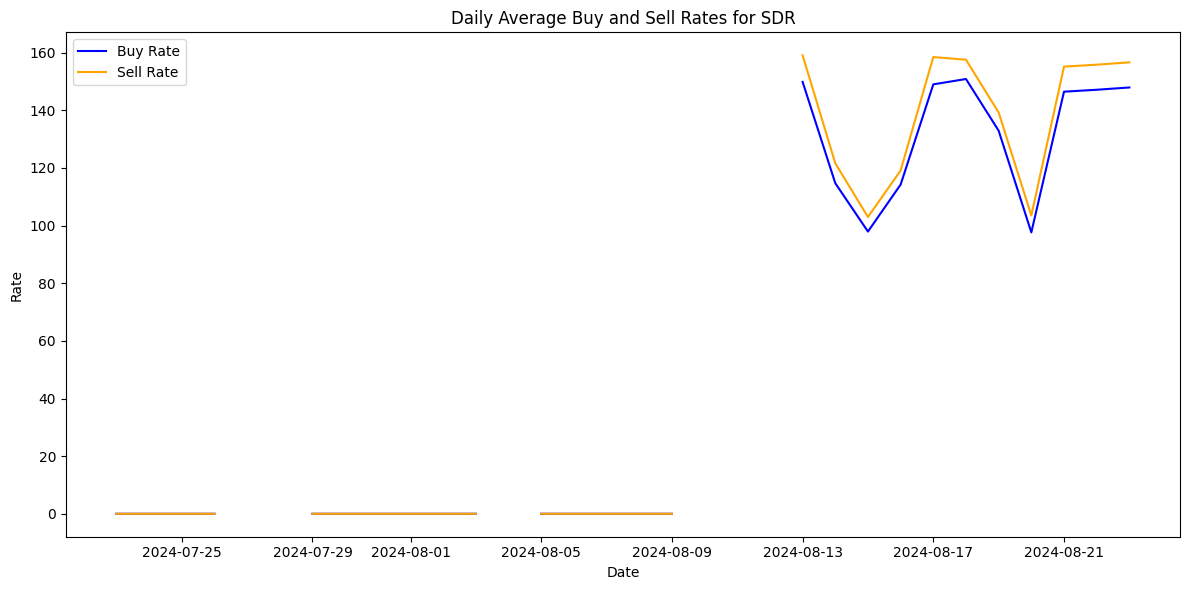

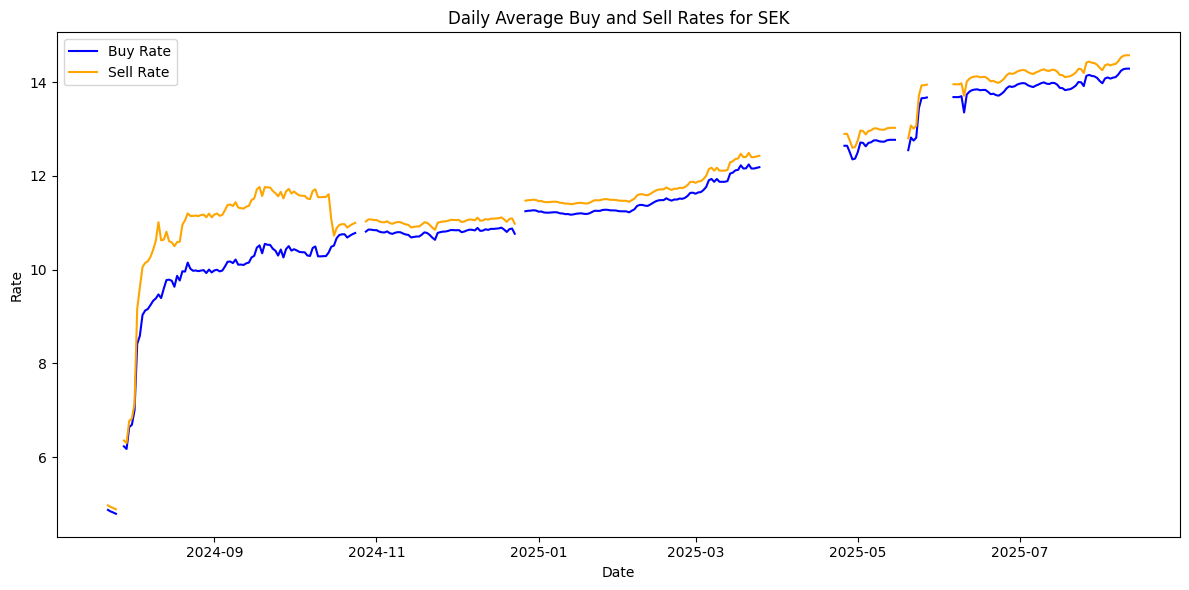

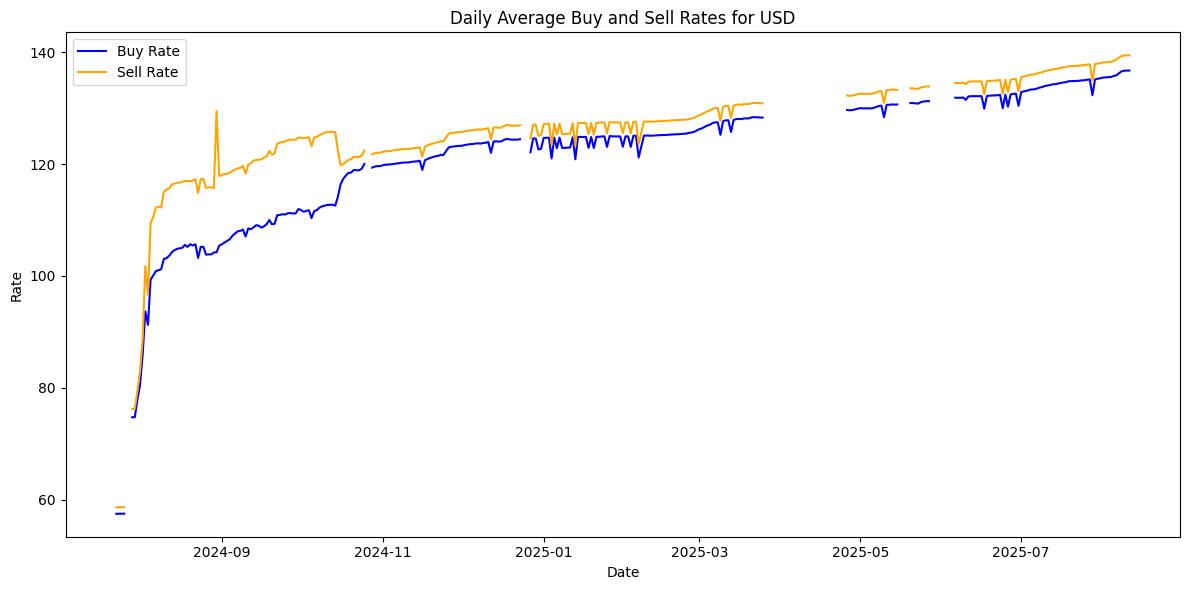

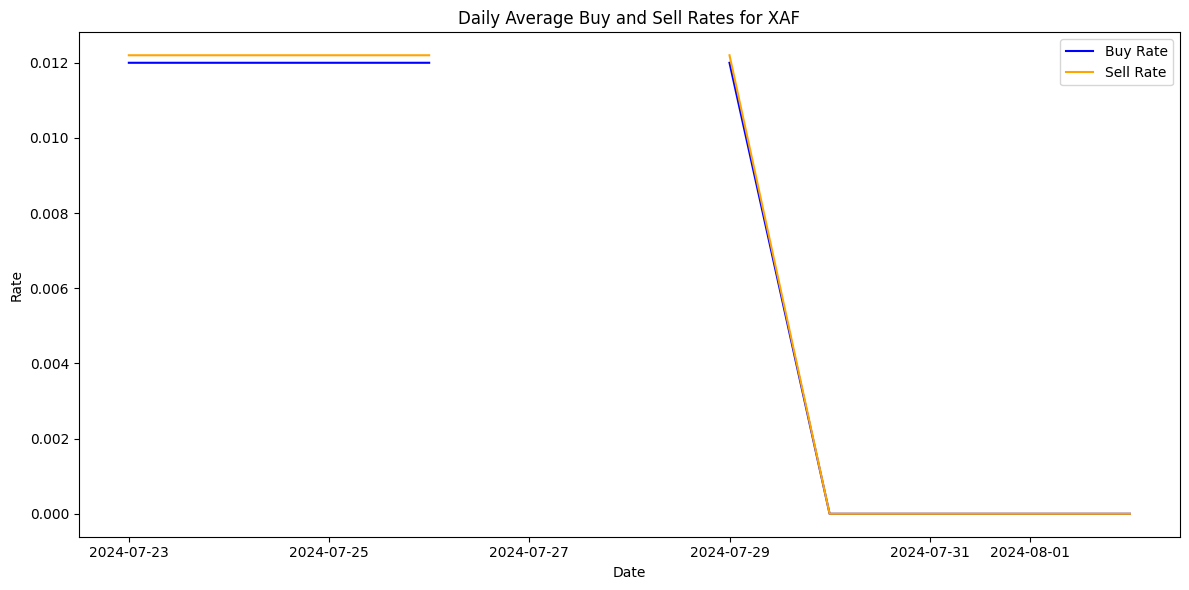

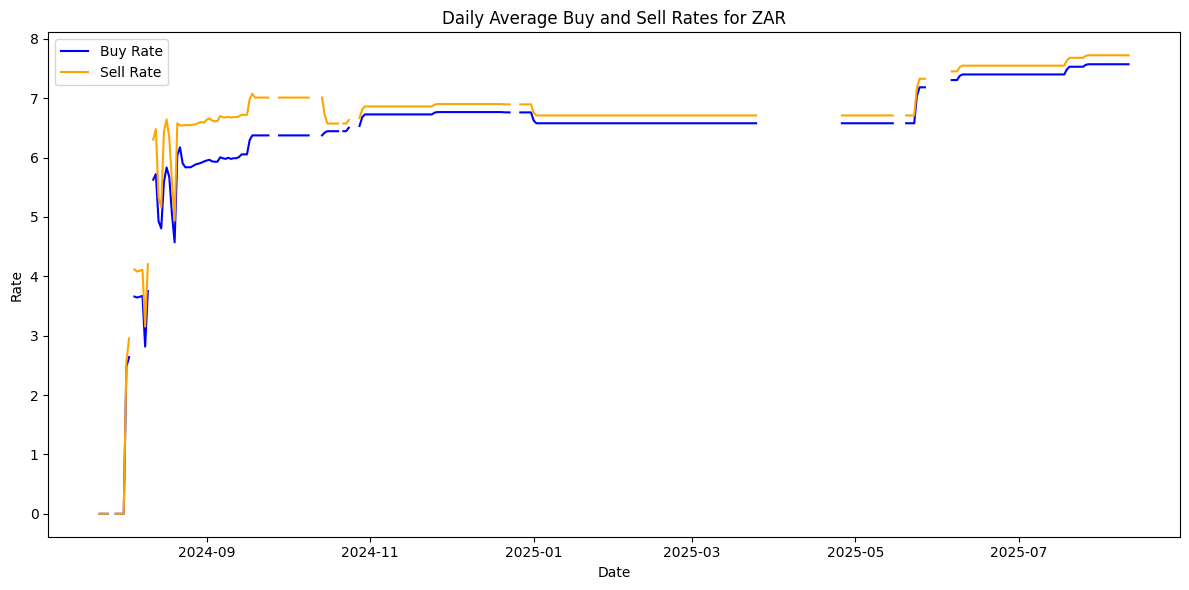

In [120]:
currencies = daily_avg_per_currency['currency_name'].unique()

for currency in currencies:
    df_curr = daily_avg_per_currency[daily_avg_per_currency['currency_name'] == currency].set_index('created_at')

    plt.figure(figsize=(12, 6))
    plt.plot(df_curr.index, df_curr['buy_rate'], label='Buy Rate', color='blue')
    plt.plot(df_curr.index, df_curr['sell_rate'], label='Sell Rate', color='orange')
    plt.title(f'Daily Average Buy and Sell Rates for {currency}')
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.legend()
    plt.tight_layout()
    # plt.close()
    plt.show()


In [122]:
# currencies = daily_avg_per_currency['currency_name'].unique()

for currency in currencies:
    df_curr = daily_avg_per_currency[daily_avg_per_currency['currency_name'] == currency]
    # Save each currency's daily average to a separate CSV file
    output_folder = "./daily_avg_per_currency"
    os.makedirs(output_folder, exist_ok=True)
    df_curr.to_csv(f"{output_folder}/{currency}_daily_avg.csv", index=False)
    print(f"Daily average data for {currency} saved successfully.")
    print(f" daily average for {currency}: {df_curr['buy_rate'].mean()}, {df_curr['sell_rate'].mean()}")
    


Daily average data for AED saved successfully.
 daily average for AED: 31.85588550976929, 319.9933041378587
Daily average data for AUD saved successfully.
 daily average for AUD: 76.86164290307173, 79.61066465314521
Daily average data for CAD saved successfully.
 daily average for CAD: 82.17904038317319, 853.410625471067
Daily average data for CHF saved successfully.
 daily average for CHF: 130.52323405375196, 135.12574162169187
Daily average data for CNY saved successfully.
 daily average for CNY: 16.566824671959143, 17.19372341011867
Daily average data for Canadian Dollar saved successfully.
 daily average for Canadian Dollar: 86.4122, 88.14050000000002
Daily average data for DJF saved successfully.
 daily average for DJF: 0.6551708527446066, 0.6778813180008846
Daily average data for DKK saved successfully.
 daily average for DKK: 17.160166211378932, 17.757492112401202
Daily average data for EUR saved successfully.
 daily average for EUR: 132.70885947802716, 137.0333654936658
Daily a